In [48]:
import numpy as np
import scanpy as sc
import os
import anndata
import matplotlib.pyplot as plt
import scipy
from matplotlib.pyplot import figure
import copy
import json
import gseapy
from gseapy import enrichr
from mpmath import *
from scipy.sparse import csr_matrix, vstack, hstack
from scipy import sparse
from anndata import AnnData

In [2]:
hvmask = np.load('hvmask.npy')
hvmask.sum()

6030

In [3]:
import os
import umap

In [4]:
gtdata = anndata.read_h5ad('gtdata_final.h5ad')
semisdata = anndata.read_h5ad('semisdata_final.h5ad')

In [5]:
semisdata.obs['celltypes'] = semisdata.obs['initial_clustering']

In [6]:
semisdata.X.max()

9.141516

In [8]:
totaltypes = np.unique(gtdata.obs['celltypes'])
#selected_types=['B_cell', 'CD14', 'CD16', 'CD4', 'CD8', 'DCs']
for ctype in totaltypes:
    
    semitypedata = semisdata[semisdata.obs['celltypes']==ctype]
    gttypeda = gtdata[gtdata.obs['celltypes']==ctype]

    # gttypeda.write(str(ctype)+'_gtdata.h5ad')
    # semitypedata.write(str(ctype)+'_semidata.h5ad')
        
    print(str(ctype)+'_semidata_sparse.h5ad',str(gttypeda.X.shape[0]))
    
    gtsps = sparse.csr_matrix(np.array(gttypeda.X))
    semisps = sparse.csr_matrix(np.array(semitypedata.X))
    
    gttypedata = anndata.AnnData(gtsps)
    gttypedata.obs = gttypeda.obs
    gttypedata.var = gttypeda.var
    gttypedata.obsm = gttypeda.obsm
    gttypedata.uns = gttypeda.uns
    gttypedata.obsp = gttypeda.obsp
    
    semitypedatasps = anndata.AnnData(semisps)
    semitypedatasps.obs = semitypedata.obs
    semitypedatasps.var = semitypedata.var
    semitypedatasps.obsm = semitypedata.obsm
    semitypedatasps.uns = semitypedata.uns
    semitypedatasps.obsp = semitypedata.obsp
    
    gttypedata.write('typedata/'+str(ctype)+'_gtdata_sparse.h5ad')
    semitypedatasps.write('typedata/'+str(ctype)+'_semidata_sparse.h5ad')

B_cell_semidata_sparse.h5ad 64292
CD14_semidata_sparse.h5ad 121129
CD16_semidata_sparse.h5ad 20391
CD4_semidata_sparse.h5ad 144201
CD8_semidata_sparse.h5ad 100489
DCs_semidata_sparse.h5ad 6902
HSC_semidata_sparse.h5ad 3295
Lymph_prolif_semidata_sparse.h5ad 7020
MAIT_semidata_sparse.h5ad 6746
Mono_prolif_semidata_sparse.h5ad 647
NK_16hi_semidata_sparse.h5ad 93483
NK_56hi_semidata_sparse.h5ad 11376
Plasmablast_semidata_sparse.h5ad 9796
Platelets_semidata_sparse.h5ad 16684
RBC_semidata_sparse.h5ad 2423
Treg_semidata_sparse.h5ad 13065
gdT_semidata_sparse.h5ad 10441
pDC_semidata_sparse.h5ad 4764


In [265]:
gtdata.write('gtdata_final.h5ad')
semisdata.write('semisdata_final.h5ad')

In [105]:

pids=[]
f = open('sids.txt','r')
lines=f.readlines()
for l in lines:
    pids.append(l.strip())

pnum = 28
rnd = int(pnum/4)
    
reprefile = 'training_rec/eer_representatives_'+str(rnd)+'.txt'    #6000genebackup/
#'eer_representatives_'+str(rnd)+'.txt' #'init_representatives_4.txt'    #'uncertainty2_representatives.txt'
clusterfile = 'training_rec/eer_cluster_labels_'+str(rnd)+'.txt'
#'eer_cluster_labels_'+str(rnd)+'.txt' #'init_cluster_labels_4.txt'      #'uncertainty2_cluster_labels.txt'

f= open(reprefile,'r')
lines=f.readlines()
representatives=[]
for l in lines:
    representatives.append(int(l.strip().split()[0]))
f.close()

f= open(clusterfile,'r')
cluster_labels=[]
lines=f.readlines()
for l in lines:
    cluster_labels.append(int(l.strip().split()[0]))
f.close()


In [106]:

pids=[]
f = open('sids.txt','r')
lines=f.readlines()
for l in lines:
    pids.append(l.strip())

reprefile = 'init_representatives_4.txt'    #'uncertainty2_representatives.txt'
clusterfile = 'init_cluster_labels_4.txt'      #'uncertainty2_cluster_labels.txt'

f= open(reprefile,'r')
lines=f.readlines()
init_representatives=[]
for l in lines:
    init_representatives.append(int(l.strip().split()[0]))
f.close()

f= open(clusterfile,'r')
init_cluster_labels=[]
lines=f.readlines()
for l in lines:
    init_cluster_labels.append(int(l.strip().split()[0]))
f.close()

In [108]:
hvmask = np.load('hvmask.npy')
setmask = np.load('hvset.npy')

In [179]:
## load and pca together
import timeit 

t_start = timeit.default_timer()

#representatives = new_representatives#init_representatives  # newrepre
#cluster_labels = new_cluster_labels  #init_cluster_labels #nlabels
status = []
status_collection = []
states_collection_sum = []
sampleids=[]
worst_status = []
celltypes = []
subtypes = []
gts=[]
semis=[]

semi_status_collection =[ ]
semi_states_collection_sum = []
semi_status = []

semirepmask = []
semisampleids = []


for i in range(len(pids)):
    pid = pids[i]
    
    adata = anndata.read_h5ad('sample_sc/'+pid+'.h5ad')
    sampleid = adata.obs['sample_id'][0]
    subtype = adata.obs['full_clustering']
    celltype = adata.obs['initial_clustering']
    status.append(adata.obs['Status'])
    status_collection.append(adata.obs['Status_on_day_collection'])
    states_collection_sum.append(list(adata.obs['Status_on_day_collection_summary']))
    worst_status.append(adata.obs['Worst_Clinical_Status'])
    x = adata.X[:,hvmask]
    x = x.todense()
    x = np.array(x)
    x = np.log1p(x)
    #x = sparse.csr_matrix(x)
    gts.append(x) ####### loadiing thresholded gt data
    repre = representatives[cluster_labels[i]]
    reprepid = pids[repre]
    if reprepid==pid:
        semis.append(x)
        xsem = x
        for j in range(x.shape[0]):
            semirepmask.append(1)
    else:
        
        xsem = np.load('semidata/fast'+ reprepid+'_to_'+pid+'.npy') # 6000genebackup/
        xsem = np.array(xsem)
        xsem = xsem * (xsem>10)  # threshold
        xsem = np.log(xsem+1)  # log1p
        #xsem = sparse.csr_matrix(x)
        semis.append(xsem)
        for j in range(xsem.shape[0]):
            semirepmask.append(0)
        
    sampleids.append(adata.obs['sample_id'])
    ssc = []
    sscs = []
    ss = []
    semisampleid = []
    for j in range(xsem.shape[0]):
        ssc.append(status_collection[-1][0])
        sscs.append(states_collection_sum[-1][0])
        ss.append(status[-1][0])
        semisampleid.append(sampleid)
    semi_status_collection.append(ssc)
    semi_states_collection_sum.append(sscs)
    semi_status.append(ss)
    semisampleids.append(semisampleid)
    
    celltypes.append(celltype)
    subtypes.append(subtype)
    print(i,end=', ')

#X = np.concatenate([np.array(gts),np.array(xsemis)],axis=0)
#pca = PCA(n_components=100)
#X_PCA = pca.fit_transform(X)
#umap_reduc=umap.UMAP()
#X_UMAP = umap_reduc.fit_transform(X_PCA)

t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'seconds')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 
76.51101755094714 seconds


In [112]:
### highly variable gts
for i in range(len(pids)):
    if gts[i].shape[1] != hvmask.sum():
        #print(gts[i].shape[1])
        gts[i] = gts[i][:,hvmask]

In [113]:
for i in range(len(pids)):
    if semis[i].shape[1] != hvmask.sum():
        semis[i] = semis[i][:,hvmask]

In [114]:
# log scale sanity check
for i in range(len(pids)):
    if gts[i].max()>10:
        print(gts[i].max())
    if semis[i].max()>10:
        print(semis[i].max())

In [116]:
len(xsemis)

665605

In [115]:
#xsemis = sparse.vstack(semis)
xsemis = np.concatenate(semis,axis=0)
tx = xsemis
tx = tx[tx>0]
print(tx.min())

2.3978953


In [117]:
## PCA  # no need if with dim alldata is loaded
from sklearn.decomposition import PCA

t_start = timeit.default_timer()
#xsemis = np.concatenate(semis,axis=0)
#xsemis = xsemis*(xsemis>np.log1p(1))
#X = sparse.vstack([sparse.vstack(gts),xsemis]) #semidata.X],axis=0)
X = np.concatenate([np.concatenate(gts,axis=0),xsemis],axis=0)
#pca = PCA(n_components=100)
reducer =  PCA(n_components=100)#TruncatedSVD(n_components=100) 

X_reduced = reducer.fit_transform(np.array(X))
#umap_reduc=umap.UMAP()
#X_UMAP = umap_reduc.fit_transform(X_PCA)

### harmony
#reddata = anndata.AnnData(X)
#reddata.obs['batch'] = batch
#reddata.obsm['X_pca'] = X_reduced
#from harmony import harmonize
#X_reduced = harmonize(reddata.obsm['X_pca'], reddata.obs, batch_key = 'batch')
#reddata.obsm['X_harmony'] = X_reduced

t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'seconds')


173.94266452209558 seconds


In [118]:
# get length of gt and semi

offset=0
lengt = 0
gtpids = []
for i in range(len(pids)):
    offset = offset+gts[i].shape[0]
    for j in range(gts[i].shape[0]):
        gtpids.append(pids[i])
lengt = offset
semipids = []
for i in range(len(pids)):
    offset = offset+semis[i].shape[0]
    for j in range(semis[i].shape[0]):
        semipids.append(pids[i])
totallen = offset
lensemi = totallen-lengt

In [119]:
np.save('X_reduced',X_reduced)

In [124]:
batch = []
xdimgts=[]
xdimsemis=[]
repmask = []
offset=0
xused = X_reduced#X_UMAP#X_reduced#X_UMAP # X_PCA
lengt = 0
c = 0
for i in range(len(pids)):
    xdimgts.append(xused[offset:(offset+gts[i].shape[0]),:])
    offset = offset+gts[i].shape[0]
    for j in range(len(gts[i])):
        batch.append(c)
    if i in representatives:
        for j in range(len(gts[i])):
            repmask.append(1)
    else:
        for j in range(len(gts[i])):
            repmask.append(0)
    c+=1
lengt = offset
semirepmask = []
for i in range(len(pids)):
    xdimsemis.append(xused[offset:(offset+semis[i].shape[0]),:])
    offset = offset+semis[i].shape[0]
    for j in range(len(semis[i])):
        batch.append(c)
    if i in representatives:
        for j in range(len(semis[i])):
            semirepmask.append(1)
    else:
        for j in range(len(semis[i])):
            semirepmask.append(0)
    c+=1
totallen = offset
lensemi = totallen-lengt

In [125]:
gtdata = anndata.AnnData(np.concatenate(gts,axis=0))
gtdata.obs['status'] = np.concatenate(status)
gtdata.obs['status_collection'] = np.concatenate(status_collection)
gtdata.obs['states_collection_sum'] = np.concatenate(states_collection_sum)
#gtdata.obs['worst_status'] = np.concatenate(worst_status)
gtdata.obs['sample_id'] = np.concatenate(sampleids,axis=0)
gtdata.obs['celltypes'] = np.concatenate(celltypes)
gtdata.obs['subtypes'] = np.concatenate(subtypes)
gtdata.var = adata.var[hvmask]

In [126]:
semisdata = anndata.AnnData(xsemis)#np.concatenate(semis,axis=0))
semisdata.var = adata.var[hvmask]
semisdata.obs['status'] = np.concatenate(semi_status, axis=0)
semisdata.obs['status_collection'] = np.concatenate(semi_status_collection, axis=0)
semisdata.obs['states_collection_sum'] = np.concatenate(semi_states_collection_sum, axis=0)
semisdata.obs['sampleids'] = np.concatenate(semisampleids,axis=0)

rms=  []
for i in semirepmask:
    if i == 0:
        rms.append('Semi-profiled')
    else:
        rms.append('Representatives')        

semisdata.obs['repmask'] = semirepmask

In [127]:
# save pca & umap for gt data
if 'X_pca_joint' not in gtdata.obsm:
    gtdata.obsm['X_pca_joint'] = X_reduced[:lengt]
# save pca & umap for semisdata
if 'X_pca_joint' not in semisdata.obsm:
    semisdata.obsm['X_pca_joint'] = X_reduced[lengt:]
semisdata.obsm['X_pca'] = (np.array(X_reduced))[lengt:]
gtdata.obsm['X_pca'] = (np.array(X_reduced))[:lengt]

In [128]:
semisdata.write('semisdata_pca.h5ad')
gtdata.write('gtdata_pca.h5ad')

In [129]:
datalb = []
for i in range(gtdata.X.shape[0]):
    datalb.append('Original')
for i in range(semisdata.X.shape[0]):
    datalb.append('Semi-profiled')

In [130]:
# create combined data for scanpy umap
combdata = anndata.AnnData(np.concatenate([gtdata.X,semisdata.X],axis=0))
combdata.obsm['X_pca'] = np.array(X_reduced)
combdata.obs['label'] = datalb
combdata.var = gtdata.var

In [131]:
sc.pp.neighbors(combdata,n_neighbors=50)

In [132]:
combdata.write('combdata_neighbors_50.h5ad')

In [133]:
sc.tl.umap(combdata,min_dist=0.1)

In [134]:
combdata.write('combdata_umap_50_0.1.h5ad')

In [38]:
combdata = anndata.read_h5ad('combdata_umap_50_0.1.h5ad')

In [55]:
#combdata = anndata.read_h5ad('combdata_neighbors_50_0.1.h5ad')

In [ ]:
#sc.pp.neighbors(combdata,n_neighbors=min(combdata.X.shape[0]//5000,100))#,n_neighbors=30)
#c#ombdata.X.shape[0]//5000

In [65]:
#combdata.write('combdata_neighbors_'+str(min(combdata.X.shape[0]//5000,100))+'.h5ad')

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


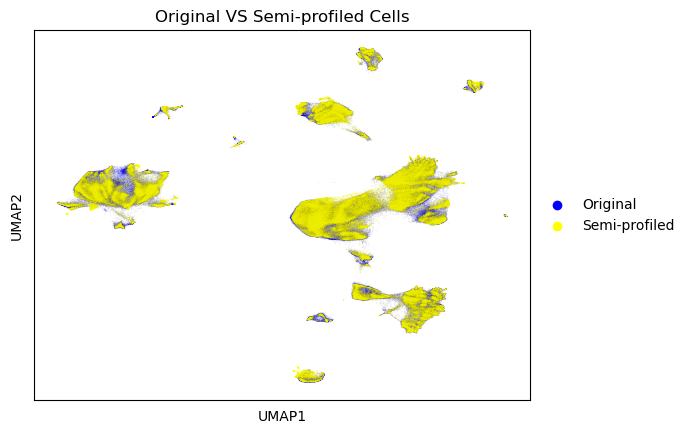

In [136]:
pointsize = 120000 / combdata.X.shape[0] * 15
#color_map = 'magma'

palette = {'Original':'blue','Semi-profiled':'yellow'}
sc.pl.umap(combdata,color = 'label',
           title = 'Original VS Semi-profiled Cells',
           size = pointsize,
           palette = palette,
           save='ori vs semi t10 50 01 .pdf',
           alpha=0.1)

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


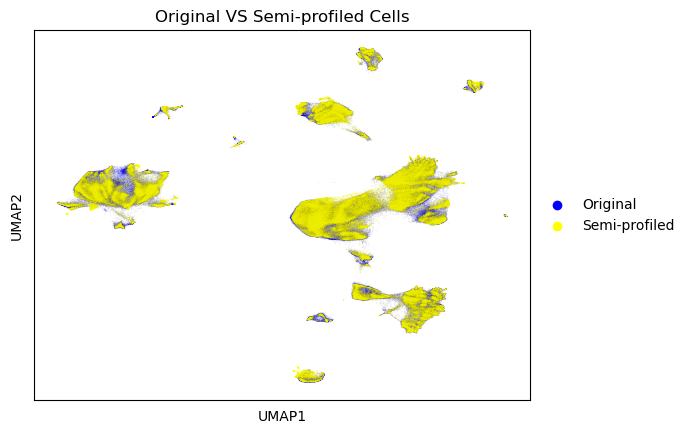

In [40]:
pointsize = 120000 / combdata.X.shape[0] * 15
#color_map = 'magma'

palette = {'Original':'blue','Semi-profiled':'yellow'}
sc.pl.umap(combdata,color = 'label',
           title = 'Original VS Semi-profiled Cells',
           size = pointsize,
           palette = palette,
           show=False,
           #save='ori vs semi t10 50 01 .pdf',
           alpha=0.1)

fname = '117 ori vs semi t10 50 01 dpi600'
plt.savefig(fname+'.jpg', dpi=600, bbox_inches='tight')
    

In [ ]:
#sc.pl.umap(combdata,color = 'label',title = 'Original VS Semi-profiled Cells',save='ori vs semi 100 0d1.pdf')

In [137]:

gtdata.obsm['X_umap'] = combdata.obsm['X_umap'][:lengt]
semisdata.obsm['X_umap'] = combdata.obsm['X_umap'][lengt:]

In [138]:
gtdata.write('gtdata_umap.h5ad')
semisdata.write('semisdata_umap.h5ad')

In [139]:
gtdata.obs['repmask'] = repmask
gtdata.write('gtdata_umap.h5ad')

In [140]:
totaltypes = np.unique(gtdata.obs['celltypes'])

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


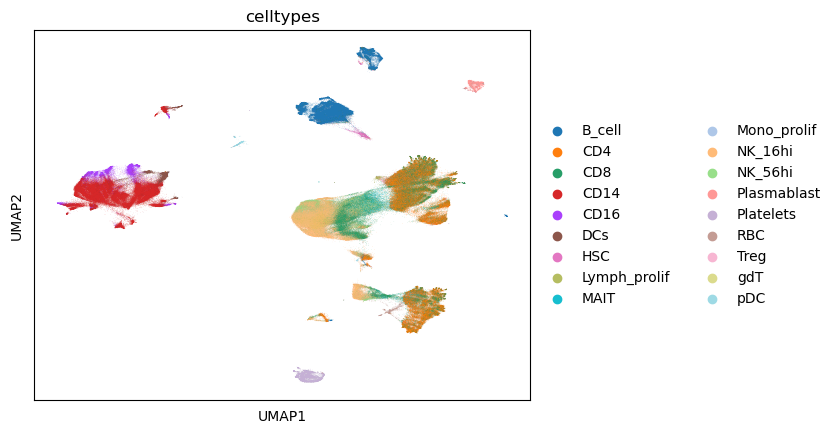

In [266]:
sc.pl.umap(semisdata,color='celltypes',save='celltype semis umap.pdf')

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


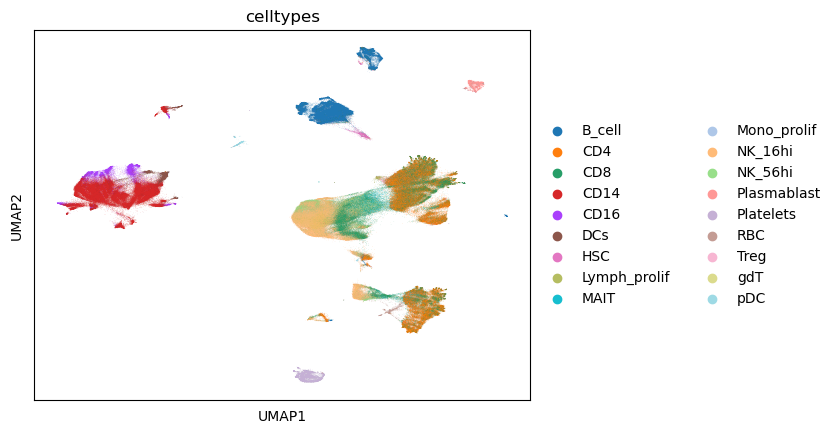

In [42]:
sc.pl.umap(semisdata,color='celltypes',show=False)
fname = 'covid celltype semi umap dpi600'
plt.savefig(fname+'.jpg', dpi=600, bbox_inches='tight')
    

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


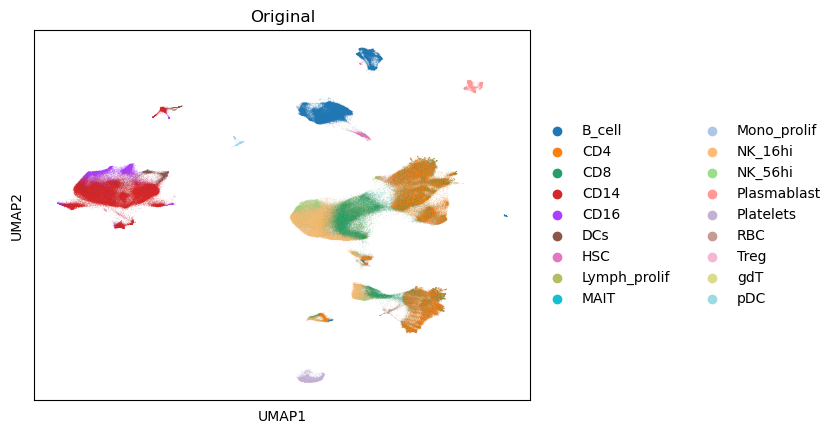

In [141]:
## only gt
gtdata.obs['ft'] = np.concatenate(celltypes,axis=0)
sc.pl.umap(gtdata,color = 'ft',title='Original',save='celltypeoriginalumap.pdf')

In [43]:
gtdata

AnnData object with n_obs × n_vars = 637144 × 6030
    obs: 'status', 'status_collection', 'states_collection_sum', 'celltypes', 'subtypes', 'repmask', 'ft', 'IFN_score', 'sample_ids', 'sample_id', 'initial_clustering'
    var: 'feature_types'
    uns: 'celltypes_colors', 'celltypes_sizes', 'ft_colors', 'neighbors', 'paga', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_joint', 'X_umap'
    obsp: 'connectivities', 'distances'

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


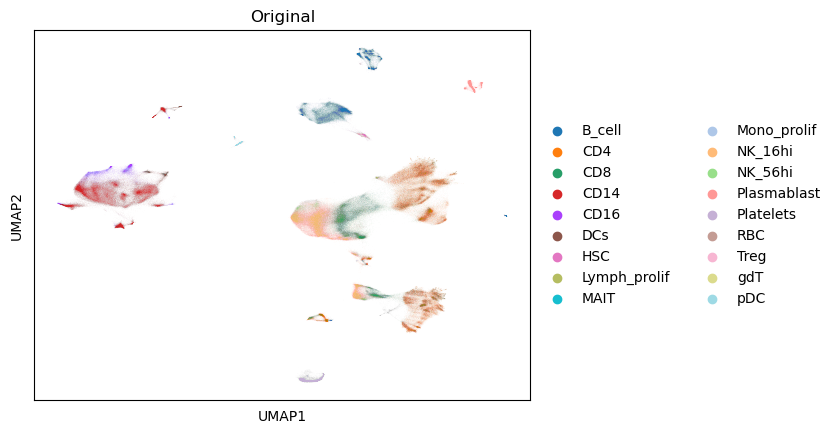

In [46]:

sc.pl.umap(gtdata,color = 'ft',title='Original',alpha=0.1,show=False)
fname = 'covid celltype gt umap a01 dpi600'
plt.savefig(fname+'.jpg', dpi=600, bbox_inches='tight')

In [142]:
#sc.pl.umap(semisdata,color = 'initial_clustering',title='Semi-profiled',save='celltypesemisumap.pdf')

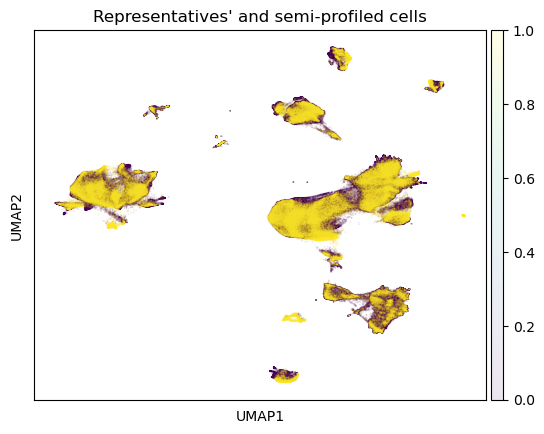

In [143]:

pointsize = 120000 / semisdata.X.shape[0] * 15 * 2
palette = {'Representatives':'purple','Semi-profiled':'yellow'}
sc.pl.umap(semisdata, color = 'repmask',size = pointsize,palette = palette,title = 'Representatives'+"'"+' and semi-profiled cells',alpha = 0.1,  save = ' 1007 rep vs non.pdf')

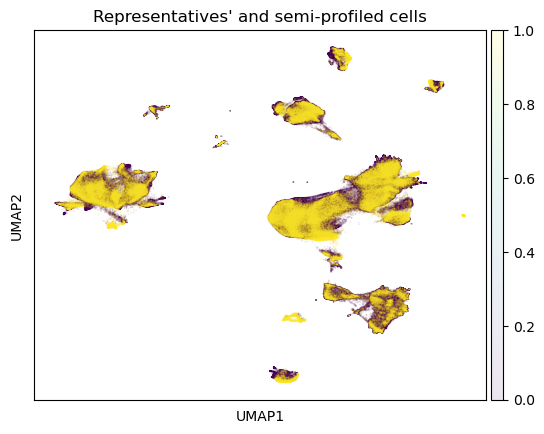

In [45]:
pointsize = 120000 / semisdata.X.shape[0] * 15 * 2
palette = {'Representatives':'purple','Semi-profiled':'yellow'}
sc.pl.umap(semisdata, color = 'repmask',size = pointsize,palette = palette,title = 'Representatives'+"'"+' and semi-profiled cells',alpha = 0.1,  show=False)
fname = 'covid repmask umap dpi600'
plt.savefig(fname+'.jpg', dpi=600, bbox_inches='tight')



### Deconv

In [144]:
import sklearn
from sklearn.svm import LinearSVC

In [148]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

linearSVM = MLPClassifier()#MLPClassifier()#LinearSVC()
#linearSVM.fit(((x_train-20)*(x_train>20)), y_train)
xtrain=[]
ytrain=[]
for i in (representatives):
    xtrain.append(gts[i])
    ytrain.append(celltypes[i])
xtrain = np.concatenate(xtrain,axis=0)
ytrain = np.concatenate(ytrain,axis=0)
linearSVM.fit((xtrain),ytrain)

MLPClassifier()

In [149]:
def deconv(svc,xtest):
    ytest = svc.predict((xtest))
    return list(ytest)

In [150]:
# get predicted label 

pcelltypes = []

for i in range(len(pids)):
    if i in representatives:
        pcelltypes.append(celltypes[i])
        continue
    pcelltypes.append(list(deconv(linearSVM,semis[i])))


In [151]:
totaltypes = np.unique(np.concatenate(celltypes,axis=0))
totalsubtypes =  np.unique(np.concatenate(subtypes,axis=0))

In [152]:
def prop(gttypes ,semitypes, totaltypes):
    pgt = np.zeros(totaltypes.shape)
    psemi = np.zeros(totaltypes.shape)
    for i in range(len(totaltypes)):
        pgt[i] += (np.array(gttypes) == totaltypes[i]).sum()
        psemi[i] += (np.array(semitypes) == totaltypes[i]).sum()  ## celltypes2
    numgt=pgt
    numsemi=psemi
    pgt = pgt/pgt.sum()
    psemi = psemi/psemi.sum()
    pcor,pval = scipy.stats.pearsonr(pgt,psemi)
    return pcor,pval,pgt,psemi,numgt,numsemi

def RMSE(p1,p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    mse = ((p1-p2)**2).sum()
    rmse = mse**0.5
    return rmse

In [153]:
# get pcors
pcors = []
pgts=[]
psemis=[]
numgts = []
numsemis = []
prmses = []
for i in range(len(pids)):
    if i in representatives:
        pcor, pval, pgt, psemi, numgt, numsemi = prop(celltypes[i],celltypes[i],totaltypes)
    pcor, pval, pgt, psemi, numgt, numsemi = prop(celltypes[i],pcelltypes[i],totaltypes)
    pcors.append(pcor)
    pgts.append(pgt)
    psemis.append(psemi)
    numgts.append(numgt.astype('float'))
    numsemis.append(numsemi.astype('float'))
    prmses.append(RMSE(pgt,psemi))

In [46]:
pcor

0.9079931634021194

In [49]:
np.mean(prmses)

0.1463926387102975

In [154]:
#states_collection_sum = []
#for i in range(len(pids)):
#    pid = pids[i]
#    adata = anndata.read_h5ad('COVID_HV_GT/'+pid+'.h5ad')
#    states_collection_sum.append(list(adata.obs['Status_on_day_collection_summary'])[0])

In [155]:
asympgt = np.zeros(totaltypes.shape)
criticalgt = np.zeros(totaltypes.shape)
healthygt = np.zeros(totaltypes.shape)
lps10hgt = np.zeros(totaltypes.shape)
lps90mingt = np.zeros(totaltypes.shape)
mildgt = np.zeros(totaltypes.shape)
moderategt = np.zeros(totaltypes.shape)
severegt = np.zeros(totaltypes.shape)
noncovidgt = np.zeros(totaltypes.shape)

asympsemi = np.zeros(totaltypes.shape)
criticalsemi = np.zeros(totaltypes.shape)
healthysemi = np.zeros(totaltypes.shape)
lps10hsemi = np.zeros(totaltypes.shape)
lps90minsemi = np.zeros(totaltypes.shape)
mildsemi = np.zeros(totaltypes.shape)
moderatesemi = np.zeros(totaltypes.shape)
severesemi = np.zeros(totaltypes.shape)
noncovidsemi = np.zeros(totaltypes.shape)

for i in range(len(pids)):
    
    if states_collection_sum[i][0] == 'Healthy':
        healthygt += numgts[i]
        healthysemi += numsemis[i]
    if states_collection_sum[i][0]  == 'Asymptomatic':
        asympgt += numgts[i]
        asympsemi += numsemis[i]
    if states_collection_sum[i][0]  == 'Mild':
        mildgt += numgts[i]
        mildsemi += numsemis[i]
    if states_collection_sum[i][0]  == 'Moderate':
        moderategt += numgts[i]
        moderatesemi += numsemis[i]
    if states_collection_sum[i][0]  == 'Severe':
        severegt += numgts[i]
        severesemi += numsemis[i]
    if states_collection_sum[i][0]  == 'Critical':
        criticalgt += numgts[i]
        criticalsemi += numsemis[i]
    if states_collection_sum[i][0]  == 'LPS_90mins':
        lps90mingt += numgts[i]
        lps90minsemi += numsemis[i]
    if states_collection_sum[i][0]  == 'LPS_10hours':
        lps10hgt += numgts[i]
        lps10hsemi += numsemis[i]

In [156]:
asympgt = asympgt/asympgt.sum()
criticalgt = criticalgt/criticalgt.sum()
healthygt = healthygt/healthygt.sum()
lps10hgt = lps10hgt/lps10hgt.sum()
lps90mingt = lps90mingt/lps90mingt.sum()
mildgt = mildgt/mildgt.sum()
moderategt = moderategt/moderategt.sum()
severegt = severegt/severegt.sum()
#noncovidgt = np.zeros(totaltypes.shape)

asympsemi = asympsemi/asympsemi.sum()
criticalsemi = criticalsemi/criticalsemi.sum()
healthysemi = healthysemi/healthysemi.sum()
lps10hsemi = lps10hsemi/lps10hsemi.sum()
lps90minsemi = lps90minsemi/lps90minsemi.sum()
mildsemi = mildsemi/mildsemi.sum()
moderatesemi = moderatesemi/moderatesemi.sum()
severesemi = severesemi/severesemi.sum()
#noncovidsemi = np.zeros(totaltypes.shape)

In [157]:
colormap = ['yellow','blue','gray','red','green','black','darkgreen','darkorange','crimson',\
            'purple','navy','aquamarine','plum','violet','olive','steelblue','brown','pink']

In [158]:
import matplotlib.patches as mpatches
def stackedbar(percentages = [healthygt,asympgt,mildgt,moderategt,severegt,criticalgt],\
               totaltypes=totaltypes,\
               colormap=colormap,\
               save = True,\
               title = 'Ground Truth'\
               ):
    
    
    
    ylabels = ['Healthy','Asymptomatic','Mild','Moderate','Severe','Critical']
    
    # Create a horizontal stacked bar chart for Condition 1
    fig, [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7] = plt.subplots(8,1,figsize = (8,2))
    ax = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]
    ax0.set_title(title)
    
    
    for j in range(8):
        for i in range(len(totaltypes)):
            ax[j].barh(ylabels[j], percentages[j][i], left=sum(percentages[j][:i]),color=colormap[i])
            ax[j].set_ylabel(ylabels[j],rotation=0,ha='right',y=-0.05)
            ax[j].set_xlim([0, 1])
            ax[j].set_yticklabels([])
            ax[j].yaxis.set_tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
            if j != 7:
                ax[j].set_xticklabels([])
    
    
    patches = []
    for i in range(len(totaltypes)):
        patches.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-1].legend(handles=patches, loc='center left', bbox_to_anchor=(1.1, 5))

    '''
    patches1 = []
    for i in range(len(totaltypes)//2):
        patches1.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-2].legend(handles=patches1, loc='center left', bbox_to_anchor=(1.07, 3.8))
    
    patches2 = []
    for i in range(9,18):
        patches2.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-1].legend(handles=patches2, loc='center left', bbox_to_anchor=(1.3, 5))
    '''
    
    plt.xlabel('Proportion')
    
    if save != False:
        if save == True:
            path = 'stackedbar.png'
        else:
            path = save
        plt.savefig(path,dpi=600,bbox_inches='tight')
    # Create a legend for the chart
    #legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors_1]
    #plt.legend(legend_handles, categories_1, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the chart
    #plt.show()


In [23]:
severity=  ['Healthy','Asymptomatic','Mild','Moderate','Severe','Critical','LPS_90mins','LPS_10hours']

In [168]:
cpsemi = [healthysemi,asympsemi,mildsemi,moderatesemi,severesemi,criticalsemi,lps90minsemi,lps10hsemi]
cpgt = [healthygt,asympgt,mildgt,moderategt,severegt,criticalgt,lps90mingt,lps10hgt]
severity=  ['Healthy','Asymptomatic','Mild','Moderate','Severe','Critical','LPS_90mins','LPS_10hours']
for i in range(8):
    print(severity[i],scipy.stats.pearsonr(cpgt[i],cpsemi[i])[0])

Healthy 0.9866947826317671
Asymptomatic 0.969648554654559
Mild 0.9963328358806319
Moderate 0.9916014017326835
Severe 0.9777287881572662
Critical 0.9894580216568979
LPS_90mins 0.5572625421279966
LPS_10hours 1.0


In [ ]:
Healthy 0.9551976204172428
Asymptomatic 0.9677911389962979
Mild 0.9919990104293216
Moderate 0.9788288938063721
Severe 0.972701290278437
Critical 0.9879404731458163
LPS_90mins 0.6085970347578922
LPS_10hours 1.0

In [50]:
len(pids)

124

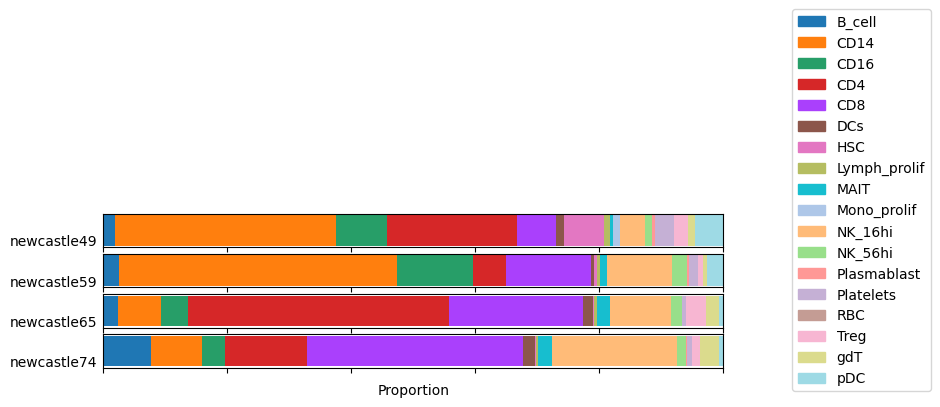

In [53]:
    #for i in range(12):
    nps = i*10
    
    ppids = pids[nps:nps+10]
    ppsemis = psemis[nps:nps+10]
    ppgts = pgts[nps:nps+10]
    ylabels = pids[nps:nps+10]
    
    ppids = pids[120:]
    ppsemis = psemis[120:]
    ppgts = pgts[120:]
    ylabels = pids[120:]
    
    # Create a horizontal stacked bar chart for Condition 1
    title =  ''
    
    
    fig, ax = plt.subplots(len(ppids),1,figsize = (8,2))
    ax[0].set_title(title)
    
    
    for j in range(len(ppids)):
        for i in range(len(totaltypes)):
            ax[j].barh(ylabels[j], ppgts[j][i], left=sum(ppgts[j][:i]),color=colormap[i])
            ax[j].set_ylabel(ylabels[j],rotation=0,ha='right',y=-0.05)
            ax[j].set_xlim([0, 1])
            ax[j].set_yticklabels([])
            ax[j].yaxis.set_tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
            #if j != 7:
            ax[j].set_xticklabels([])
    
    
    patches = []
    for i in range(len(totaltypes)):
        patches.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-1].legend(handles=patches, loc='center left', bbox_to_anchor=(1.1, 5))

    '''
    patches1 = []
    for i in range(len(totaltypes)//2):
        patches1.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-2].legend(handles=patches1, loc='center left', bbox_to_anchor=(1.07, 3.8))
    
    patches2 = []
    for i in range(9,18):
        patches2.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-1].legend(handles=patches2, loc='center left', bbox_to_anchor=(1.3, 5))
    '''
    
    plt.xlabel('Proportion')


    plt.savefig('supdeconv/gt_' + str(120) + 'to' + str(124)+ '.pdf',bbox_inches='tight')

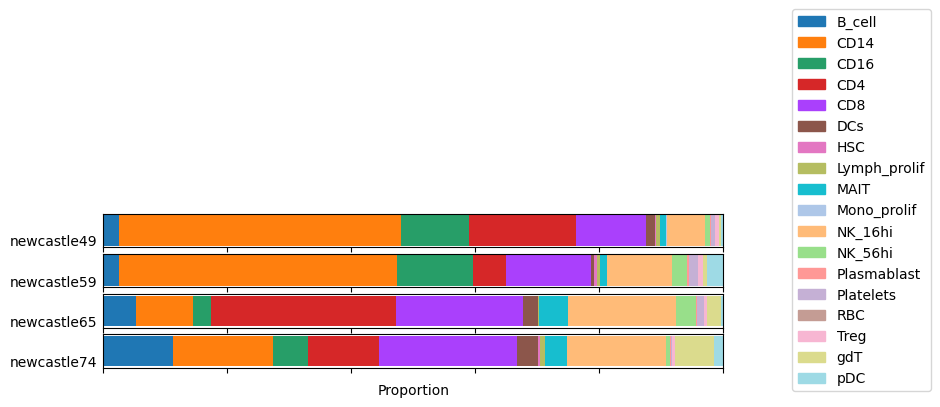

In [54]:
    #for i in range(12):
    nps = i*10
    
    ppids = pids[nps:nps+10]
    ppsemis = psemis[nps:nps+10]
    ppgts = pgts[nps:nps+10]
    ylabels = pids[nps:nps+10]
    
    ppids = pids[120:]
    ppsemis = psemis[120:]
    ppgts = pgts[120:]
    ylabels = pids[120:]
    
    # Create a horizontal stacked bar chart for Condition 1
    title =  ''
    
    
    fig, ax = plt.subplots(len(ppids),1,figsize = (8,2))
    ax[0].set_title(title)
    
    
    for j in range(len(ppids)):
        for i in range(len(totaltypes)):
            ax[j].barh(ylabels[j], ppsemis[j][i], left=sum(ppsemis[j][:i]),color=colormap[i])
            ax[j].set_ylabel(ylabels[j],rotation=0,ha='right',y=-0.05)
            ax[j].set_xlim([0, 1])
            ax[j].set_yticklabels([])
            ax[j].yaxis.set_tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
            #if j != 7:
            ax[j].set_xticklabels([])
    
    
    patches = []
    for i in range(len(totaltypes)):
        patches.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-1].legend(handles=patches, loc='center left', bbox_to_anchor=(1.1, 5))

    '''
    patches1 = []
    for i in range(len(totaltypes)//2):
        patches1.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-2].legend(handles=patches1, loc='center left', bbox_to_anchor=(1.07, 3.8))
    
    patches2 = []
    for i in range(9,18):
        patches2.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-1].legend(handles=patches2, loc='center left', bbox_to_anchor=(1.3, 5))
    '''
    
    plt.xlabel('Proportion')


    plt.savefig('supdeconv/semi_' + str(120) + 'to' + str(124)+ '.pdf',bbox_inches='tight')

### plots in the paper

In [8]:

#https://www.gsea-msigdb.org/gsea/msigdb/cards/HALLMARK_TNFA_SIGNALING_VIA_NFKB.html
TNF_genes = ["ABCA1", "ACKR3", "AREG", "ATF3", "ATP2B1", "B4GALT1", "B4GALT5", "BCL2A1", "BCL3", "BCL6", "BHLHE40", "BIRC2", "BIRC3", "BMP2", "BTG1", "BTG2", "BTG3", "CCL2", "CCL20", "CCL4", "CCL5", "CCN1", "CCND1", "CCNL1", "CCRL2", "CD44", "CD69", "CD80", "CD83", "CDKN1A", "CEBPB", "CEBPD", "CFLAR", "CLCF1", "CSF1", "CSF2", "CXCL1", "CXCL10", "CXCL11", "CXCL2", "CXCL3", "CXCL6", "DDX58", "DENND5A", "DNAJB4", "DRAM1", "DUSP1", "DUSP2", "DUSP4", "DUSP5", "EDN1", "EFNA1", 	"EGR1", 	"EGR2", "EGR3", "EHD1", "EIF1", "ETS2", "F2RL1", "F3", "FJX1", "FOS", "FOSB", "FOSL1", 	"FOSL2", 	"FUT4", 	"G0S2", 	"GADD45A", "GADD45B", "GCH1", "GEM", "GFPT2", "GPR183", "HBEGF", "HES1", "ICAM1", "ICOSLG", "ID2", "IER2", "IER3", "IER5", "IFIH1", "IFIT2", "IFNGR2", "IL12B", "IL15RA", "IL18", "IL1A", "IL1B", "IL23A", "IL6", "IL6ST", "IL7R", "INHBA", "IRF1", "IRS2", "JAG1", "JUN", "JUNB", "KDM6B", "KLF10", "KLF2", "KLF4", "KLF6", "KLF9", "KYNU", "LAMB3", "LDLR", "LIF", "LITAF", "MAFF", "MAP2K3", "MAP3K8", "MARCKS", "MCL1", 	"MSC", "MXD1", "MYC", "NAMPT", "NFAT5", "NFE2L2", "NFIL3", "NFKB1", "NFKB2", "NFKBIA", "NFKBIE", "NINJ1", "NR4A1", "NR4A2", "NR4A3", "OLR1", "PANX1", "PDE4B", "PDLIM5", "PER1", "PFKFB3", "PHLDA1", "PHLDA2", "PLAU", "PLAUR", "PLEK", "PLK2", "PLPP3", "PMEPA1", "PNRC1", "PPP1R15A", "PTGER4", "PTGS2", "PTPRE", "PTX3", "RCAN1", "REL", "RELA", "RELB", "RHOB", "RIPK2", "RNF19B", "SAT1", "SDC4", "SERPINB2", "SERPINB8", "SERPINE1", "SGK1", "SIK1", "SLC16A6", "SLC2A3", "SLC2A6", "SMAD3", "SNN", "SOCS3", "SOD2", "SPHK1", "SPSB1", "SQSTM1", "STAT5A", "TANK", "TAP1", "TGIF1", "TIPARP", "TLR2", "TNC", "TNF", "TNFAIP2", "TNFAIP3", "TNFAIP6", "TNFAIP8", "TNFRSF9", "TNFSF9", "TNIP1", "TNIP2", "TRAF1", "TRIB1", "TRIP10", "TSC22D1", "TUBB2A", "VEGFA", "YRDC", "ZBTB10", "ZC3H12A", "ZFP36"]

#https://www.gsea-msigdb.org/gsea/msigdb/cards/HALLMARK_IL6_JAK_STAT3_SIGNALING
JAK_genes = ["A2M", "ACVR1B", "ACVRL1", "BAK1", "CBL", "CCL7", "CCR1", "CD14", "CD36", "CD38", "CD44", "CD9", "CNTFR", "CRLF2", "CSF1", "CSF2", "CSF2RA", "CSF2RB", "CSF3R", "CXCL1", "CXCL10", "CXCL11", "CXCL13", "CXCL3", "CXCL9", "DNTT", "EBI3", "FAS", "GRB2", "HAX1", "HMOX1", "IFNAR1", "IFNGR1", "IFNGR2", "IL10RB", "IL12RB1", "IL13RA1", "IL15RA", "IL17RA", "IL17RB", "IL18R1", "IL1B", "IL1R1", "IL1R2", "IL2RA", "IL2RG", "IL3RA", "IL4R", "IL6", "IL6ST", "IL7", 	"IL9R", 	"INHBE", 	"IRF1", 	"IRF9", "ITGA4", "ITGB3", "JUN", "LEPR", "LTB", "LTBR", "MAP3K8", "MYD88", "OSMR", 	"PDGFC", 	"PF4", 	"PIK3R5", "PIM1", "PLA2G2A", "PTPN1", "PTPN11", "PTPN2", "REG1A", "SOCS1", "SOCS3", "STAM2", "STAT1", "STAT2", "STAT3", "TGFB1", "TLR2", "TNF", "TNFRSF12A", "TNFRSF1A", "TNFRSF1B", "TNFRSF21", "TYK2"]

#https://www.gsea-msigdb.org/gsea/msigdb/cards/GO_RESPONSE_TO_TYPE_I_INTERFERON
IFN_genes = ["ABCE1", "ADAR", "BST2", "CACTIN", "CDC37", "CNOT7", "DCST1", "EGR1", "FADD", "GBP2", 	"HLA-A", 	"HLA-B", 	"HLA-C", 	"HLA-E", 	"HLA-F", 	"HLA-G", 	"HLA-H", 	"HSP90AB1", 	"IFI27", 	"IFI35", 	"IFI6", 	"IFIT1", 	"IFIT2", 	"IFIT3", 	"IFITM1", 	"IFITM2", 	"IFITM3", 	"IFNA1", 	"IFNA10", 	"IFNA13", 	"IFNA14", 	"IFNA16", 	"IFNA17", 	"IFNA2", 	"IFNA21", 	"IFNA4", 	"IFNA5", 	"IFNA6", 	"IFNA7", 	"IFNA8", 	"IFNAR1", 	"IFNAR2", 	"IFNB1", 	"IKBKE", 	"IP6K2", 	"IRAK1", 	"IRF1", 	"IRF2", 	"IRF3", 	"IRF4", 	"IRF5", 	"IRF6", 	"IRF7", 	"IRF8", 	"IRF9", 	"ISG15", 	"ISG20", 	"JAK1", 	"LSM14A", 	"MAVS", 	"METTL3", 	"MIR21", 	"MMP12", 	"MUL1", 	"MX1", 	"MX2", 	"MYD88", 	"NLRC5", 	"OAS1", 	"OAS2", 	"OAS3", 	"OASL", 	"PSMB8", 	"PTPN1", 	"PTPN11", 	"PTPN2", 	"PTPN6", 	"RNASEL", 	"RSAD2", 	"SAMHD1", 	"SETD2", 	"SHFL", 	"SHMT2", 	"SP100", 	"STAT1", 	"STAT2", 	"TBK1", 	"TREX1", 	"TRIM56", 	"TRIM6", 	"TTLL12", 	"TYK2", 	"UBE2K", 	"USP18", 	"WNT5A", "XAF1", "YTHDF2", "YTHDF3", "ZBP1"]
#Score genes

newifn = ['A0A0G2K2T5', 'A0A1D5RHF9', 'A0A2I2YEI7', 'A0A2I2YWN8',
       'A0A2I2ZUG8', 'A0A2I3SGV5', 'A0A2I3TIW5', 'A0A337STT4',
       'A0A3Q1MAE8', 'A0A3Q1MLJ0','A0A3Q2HNN3', 'A0A3Q2L9Y3',
       'A0A5F4CY70', 'A0A5F4D1T5', 'A0A5F5XZJ2', 'A0A6I8P0E1',
       'A0A6I8PA59', 'AZI2', 'B7SVJ4', 'CH25H', 'CYP3A29', 'D4A096',
       'E1B7S4', 'F6RQE8', 'F6V335', 'F6ZD87', 'F6ZD94', 'G3QGC7',
       'G3QLG8', 'G3RSJ4', 'G3S872', 'GSONMT00008100001', 'HDAC4', 'ICP0',
       'ICP4', 'IFI27', 'IFIH1', 'IFIT1', 'IFIT3', 'IFITM1', 'IFITM2',
       'IFITM3', 'IFITM6', 'IFITM7', 'IFN', 'IFN1', 'IFNA1', 'IFNA10',
       'IFNA14', 'IFNA16', 'IFNA17', 'IFNA2', 'IFNA21', 'IFNA3', 'IFNA4',
       'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'IFNAR1', 'IFNAR1A', 'IFNAR1B',
       'IFNAR2', 'IFNB1', 'IFNE', 'IFNK', 'IFNW1', 'IKBKE', 'IRAK1',
       'IRF3', 'IRF7', 'ISG15', 'JAK1', 'LOC100050719', 'LOC100054725',
       'LOC100136541', 'LOC100136558', 'LOC100136587', 'LOC100519082',
       'LOC100551848', 'LOC100626247', 'LOC101057658', 'LOC101086599',
       'LOC101086846', 'LOC101100838', 'LOC101154761', 'LOC101158490',
       'LOC101173855', 'LOC102161418', 'LOC103104756', 'LOC103106173',
       'LOC107053353', 'LOC112441484', 'LOC112444847', 'LOC114810024',
       'LOC114810307', 'LOC422993', 'LOC475935', 'LOC483396', 'LOC483397',
       'LOC487737', 'LOC606890', 'LOC697687', 'LOC720763', 'LOC770612',
       'LOC777594', 'MAVS', 'MX1', 'MX2', 'MX3', 'MYD88', 'NR1I2',
       'OAS1A', 'OAS1C', 'OAS1D', 'OAS1E', 'OAS1F', 'OAS1G', 'OAS1H',
       'OAS2', 'Q5U778', 'RIGI', 'SETD2', 'SHFL', 'SHMT2', 'SMPD1',
       'SP100', 'STAT1', 'STAT1A', 'STAT1B', 'STAT2', 'STAT3', 'STAT4',
       'TANK', 'TBK1', 'TBKBP1', 'TRAF3', 'TREX1', 'TRIM56', 'TRIM65',
       'TYK2', 'UBIL', 'UBLP', 'W5ML39', 'W5MUZ4', 'X2KK07', 'X2KN52']
len(newifn)

147

In [163]:
#gtdata.X = gtdata.X*(gtdata.X>np.log1p(0.1))

In [7]:
#Score genes
import scanpy as sc
#sc.tl.score_genes(myeloid, TNF_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='TNF_score', random_state=0, copy=False, use_raw=None)
#sc.tl.score_genes(myeloid, JAK_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='JAK_score', random_state=0, copy=False, use_raw=None)       
#sc.tl.score_genes(myeloid, IFN_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='IFN_score', random_state=0, copy=False, use_raw=None)

In [9]:
sc.tl.score_genes(gtdata, IFN_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='IFN_score', random_state=0, copy=False, use_raw=None)

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [10]:
ifn = []
for g in IFN_genes:
    if g not in ['ABCE1', 'ADAR', 'CACTIN', 'CDC37', 'CNOT7', 'DCST1', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-E', 'HLA-F', 'HLA-H', 'HSP90AB1', 'IFNA1', 'IFNA10', 'IFNA13', 'IFNA16', 'IFNA17', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'IFNAR1', 'IRF2', 'IRF3', 'IRF6', 'JAK1', 'LSM14A', 'MIR21', 'MMP12', 'MUL1', 'NLRC5', 'PSMB8', 'PTPN1', 'PTPN11', 'PTPN2', 'PTPN6', 'SAMHD1', 'SETD2', 'SHFL', 'SHMT2', 'SP100', 'TRIM6', 'TTLL12', 'UBE2K', 'WNT5A', 'YTHDF2']:
        ifn.append(g)

In [14]:
gtdata

AnnData object with n_obs × n_vars = 637144 × 6030
    obs: 'status', 'status_collection', 'states_collection_sum', 'celltypes', 'subtypes', 'repmask', 'ft', 'IFN_score', 'sample_ids', 'sample_id', 'initial_clustering'
    var: 'feature_types'
    uns: 'celltypes_colors', 'celltypes_sizes', 'ft_colors', 'neighbors', 'paga', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_joint', 'X_umap'
    obsp: 'connectivities', 'distances'

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


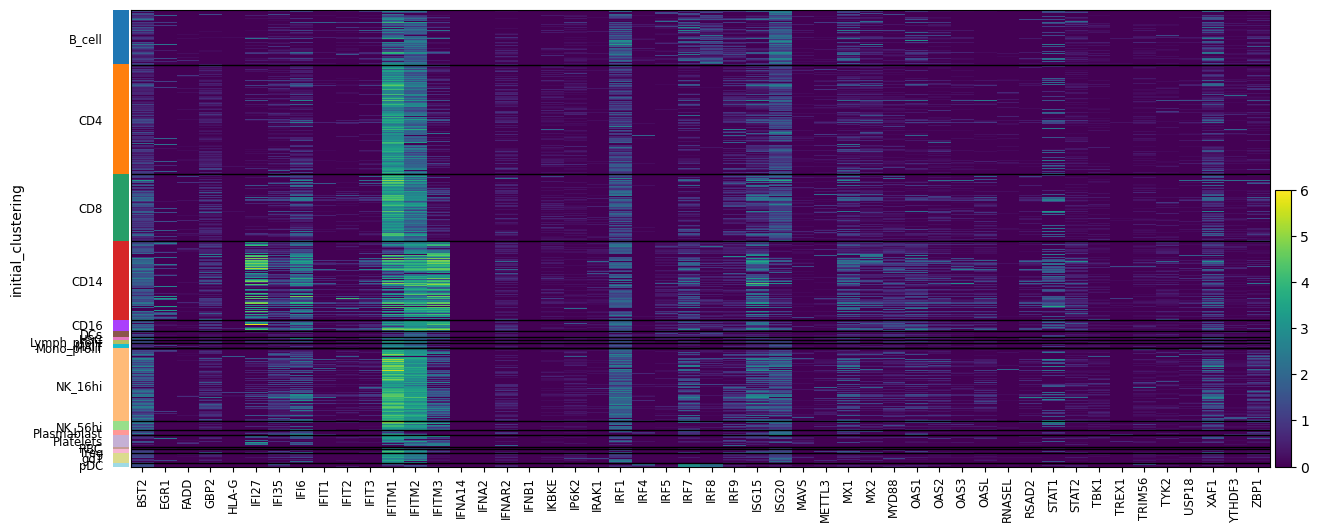

In [189]:
#sc.pl.heatmap(semisdata,ifn,groupby='initial_clustering',vmax=6)

In [17]:
totaltypes = np.unique(gtdata.obs['celltypes'])

In [11]:
len(['ABCE1', 'ADAR', 'CACTIN', 'CDC37', 'CNOT7', 'DCST1', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-E', 'HLA-F', 'HLA-H', 'HSP90AB1', 'IFNA1', 'IFNA10', 'IFNA13', 'IFNA16', 'IFNA17', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'IFNAR1', 'IRF2', 'IRF3', 'IRF6', 'JAK1', 'LSM14A', 'MIR21', 'MMP12', 'MUL1', 'NLRC5', 'PSMB8', 'PTPN1', 'PTPN11', 'PTPN2', 'PTPN6', 'SAMHD1', 'SETD2', 'SHFL', 'SHMT2', 'SP100', 'TRIM6', 'TTLL12', 'UBE2K', 'WNT5A', 'YTHDF2'])

49

In [24]:
heatscoregt = np.zeros((len(severity)-1,len(totaltypes)))
ifnscores = gtdata.obs['IFN_score']

healthyscore = np.zeros(len(totaltypes))
healthmask = gtdata.obs['states_collection_sum'] == severity[0]
for j in range(len(totaltypes)):
    typemask = np.array(gtdata.obs['celltypes']) == totaltypes[j]
    ifnscore = ifnscores[np.logical_and(healthmask,typemask)]
    healthyscore[j] = ifnscore.mean()
    
for i in range(len(severity)-1):
    sevmask = gtdata.obs['states_collection_sum'] == severity[i]
    for j in range(len(totaltypes)):
        typemask = gtdata.obs['celltypes'] == totaltypes[j]
        ifnscore = ifnscores[np.logical_and(sevmask,typemask)]
        if np.isnan(ifnscore.mean()):
            print(ifnscore)
        heatscoregt[i,j] = ifnscore.mean() - healthyscore[j]
    

Series([], Name: IFN_score, dtype: float64)
Series([], Name: IFN_score, dtype: float64)
Series([], Name: IFN_score, dtype: float64)
Series([], Name: IFN_score, dtype: float64)
Series([], Name: IFN_score, dtype: float64)


In [26]:
heatscoregt = heatscoregt[:-2]

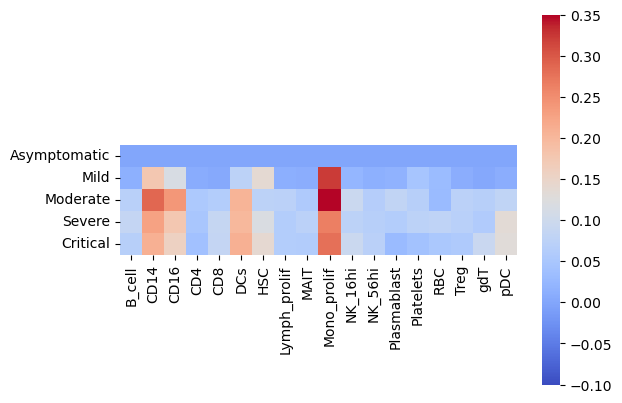

In [27]:
import seaborn as sn
sn.heatmap(heatscoregt,xticklabels = totaltypes,yticklabels=severity[1:-2],cmap="coolwarm",square = True,vmax=0.35,vmin=-0.1)
plt.savefig('results/heatmap_interferon_114.pdf')

In [ ]:
sn.heatmap(heatscore,xticklabels = totaltypes,yticklabels=severity[1:],cmap="coolwarm",square=True,vmax=0.35,vmin=-0.1)
plt.savefig('results/heatmap_interferon_semi_t10_mlp.pdf')

In [183]:
#gtdata.obs['patient_id']=gtpids
gtdata

AnnData object with n_obs × n_vars = 637144 × 6030
    obs: 'status', 'status_collection', 'states_collection_sum', 'celltypes', 'subtypes', 'repmask', 'ft', 'IFN_score', 'sample_ids'
    var: 'feature_types'
    uns: 'ft_colors'
    obsm: 'X_pca_joint', 'X_pca', 'X_umap'

In [ ]:
psevs = []
for i in range(len(pids)):
    #pmask = (np.array(gtdata.obs['patient_id']) == pids[i])
    pmask = (np.array(gtdata.obs['sample_id']) == pids[i])
    psev = np.array(gtdata.obs['states_collection_sum'])[pmask]
    psev = psev[0]
    psevs.append(psev)


In [ ]:
semissev = []
for i in range(len(pids)):
    semissev.append(np.repeat(psevs[i],len(semis[i]),axis=0))
semissev = np.concatenate(semissev,axis=0)

In [ ]:
#semisdata.obs['Status_on_day_collection_summary'] = semissev

In [29]:
sc.tl.score_genes(semisdata, IFN_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='IFN_score', random_state=0, copy=False, use_raw=None)

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [ ]:
semisdata.obs['initial_clustering'] = np.concatenate(pcelltypes,axis=0)
semisdata.obs['celltypes'] = np.concatenate(pcelltypes,axis=0)


In [ ]:
semisdata

In [31]:
heatscore = np.zeros((len(severity)-1,len(totaltypes)))
ifnscores = semisdata.obs['IFN_score']

healthyscore = np.zeros(len(totaltypes))
healthmask = semisdata.obs['states_collection_sum'] == severity[0]
for j in range(len(totaltypes)):
    typemask = np.array(semisdata.obs['celltypes']) == totaltypes[j]
    ifnscore = ifnscores[np.logical_and(healthmask,typemask)]
    healthyscore[j] = ifnscore.mean()
    
for i in range(len(severity)-1):
    sevmask = semisdata.obs['states_collection_sum'] == severity[i]
    for j in range(len(totaltypes)):
        typemask = semisdata.obs['initial_clustering'] == totaltypes[j]
        ifnscore = ifnscores[np.logical_and(sevmask,typemask)]
        heatscore[i,j] = ifnscore.mean() - healthyscore[j]
    

In [32]:
heatscore=heatscore[:-2]

In [33]:
heatscore.shape

(5, 18)

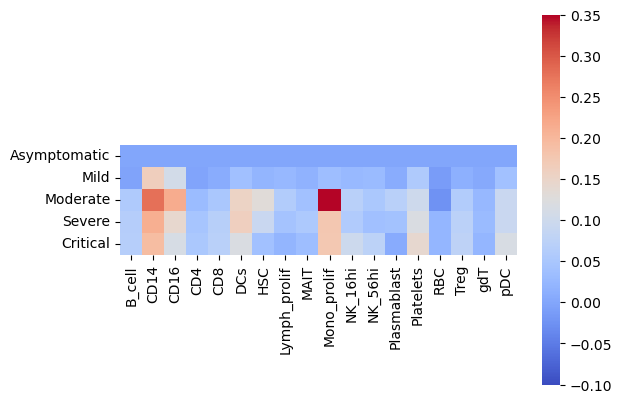

In [34]:
import seaborn as sn
sn.heatmap(heatscore,xticklabels = totaltypes,yticklabels=severity[1:-2],cmap="coolwarm",square=True,vmax=0.35,vmin=-0.1)
plt.savefig('results/heatmap_interferon_semi_114.pdf')

In [ ]:
heatscore.shape

In [ ]:
heatscoregt

In [35]:
a = np.nan_to_num(heatscore,nan=0)
a = a.reshape((-1))
b= np.nan_to_num(heatscoregt,nan=0)
b = b.reshape((-1))

In [36]:
from scipy.stats import pearsonr
pearsonr(a,b)

PearsonRResult(statistic=0.849487638509243, pvalue=3.638346117419148e-26)

In [269]:
semisdata.write('semisdata_final.h5ad')

In [270]:
gtdata.write('gtdata_final.h5ad')

In [143]:
float(hypert(gtdata.X.shape[1],100,100,c))

2.779708522575368e-59

In [14]:
np.unique(gtdata.obs['states_collection_sum'])

array(['Asymptomatic', 'Critical', 'Healthy', 'LPS_10hours', 'LPS_90mins',
       'Mild', 'Moderate', 'Non_covid', 'Severe'], dtype=object)

In [141]:
mp.dps=500

In [7]:
import scipy


# pval functions
from mpmath import *
mp.dps=500
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpmath import *
def comb(a,b):
    a=mp.mpf(a)
    b=mp.mpf(b)
    cab = fac(a)/fac(a-b)/fac(b)
    return cab

def hyperp(N,n1,n2,k):
    N = mp.mpf(N)
    n1 = mp.mpf(n1)
    n2 = mp.mpf(n2)
    k = mp.mpf(k)
    p = comb(n2,k)*comb(N-n2,n1-k)/comb(N,n1)
    return p 

def hypert(N,n1,n2,k):
    cdf = mp.mpf(0)
    for i in range(0,int(k)+1):
        cdf += hyperp(N,n1,n2,i)
       # print()
    return (1-cdf)

genesum = 6000
a = 100
b = 100
overlap = 94

p_value = hypert(genesum,a,b,overlap)
print(float(p_value))


1.466403272131815e-195


### CellType Markers Enrichment

In [16]:
### Reactome


sc.tl.rank_genes_groups(gtdata, 'celltypes', method='t-test')

typededic = {}
for j in range(totaltypes.shape[0]):
    celltype = totaltypes[j]
    typede = []
    for i in range(100):
        g = gtdata.uns['rank_genes_groups']['names'][i][j]
        typede.append(g)
        
    typededic[celltype] = typede



sc.tl.rank_genes_groups(semisdata, 'initial_clustering', method='t-test')

semitypededic = {}
for j in range(totaltypes.shape[0]):
    celltype = totaltypes[j]
    typede = []
    for i in range(100):
        g = semisdata.uns['rank_genes_groups']['names'][i][j]
        typede.append(g)
        
    semitypededic[celltype] = typede

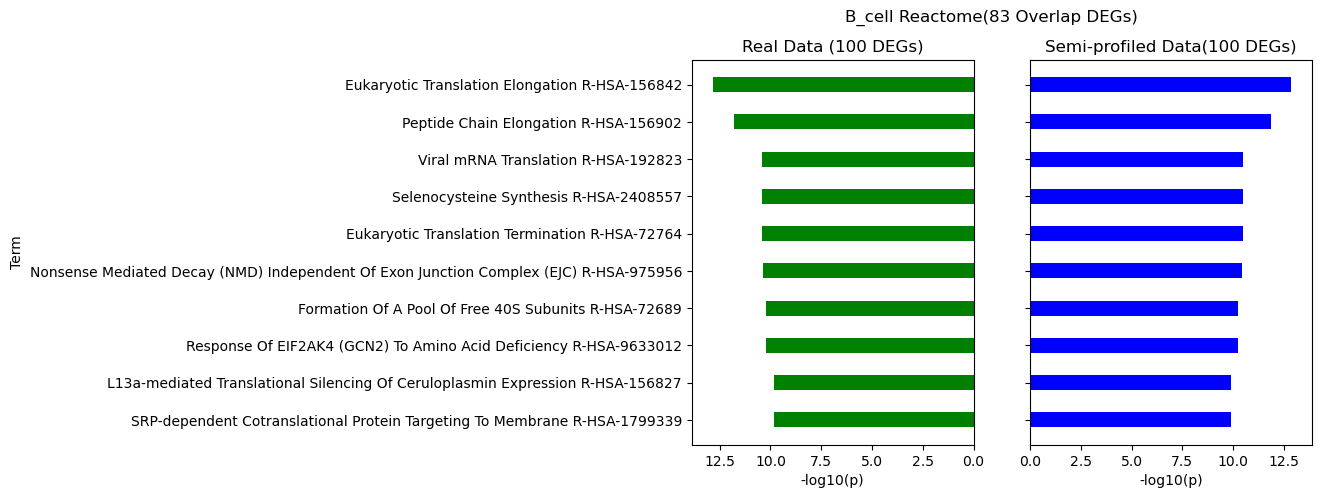

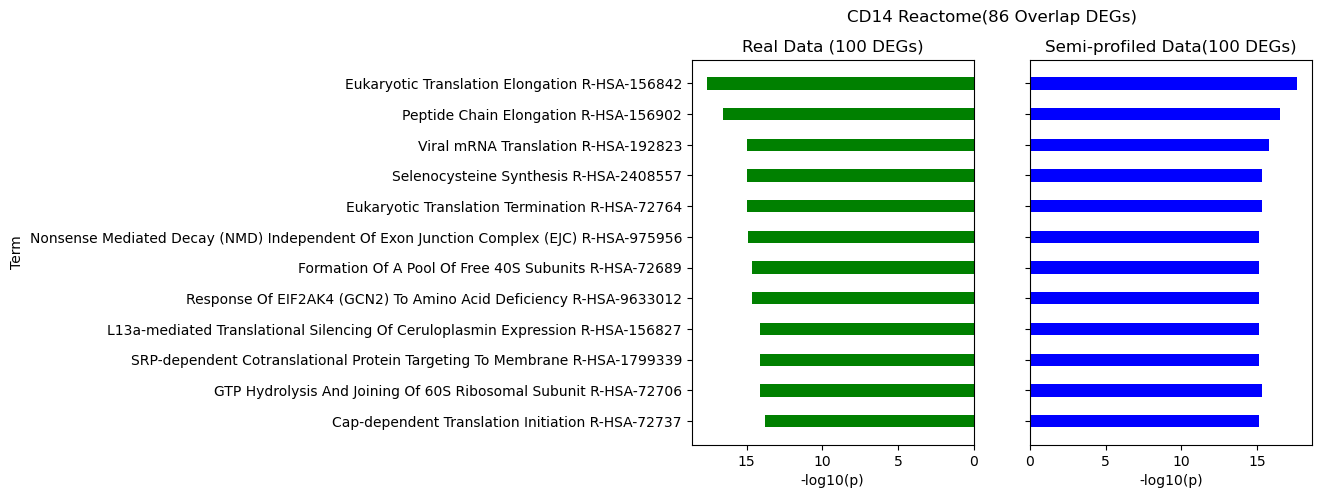

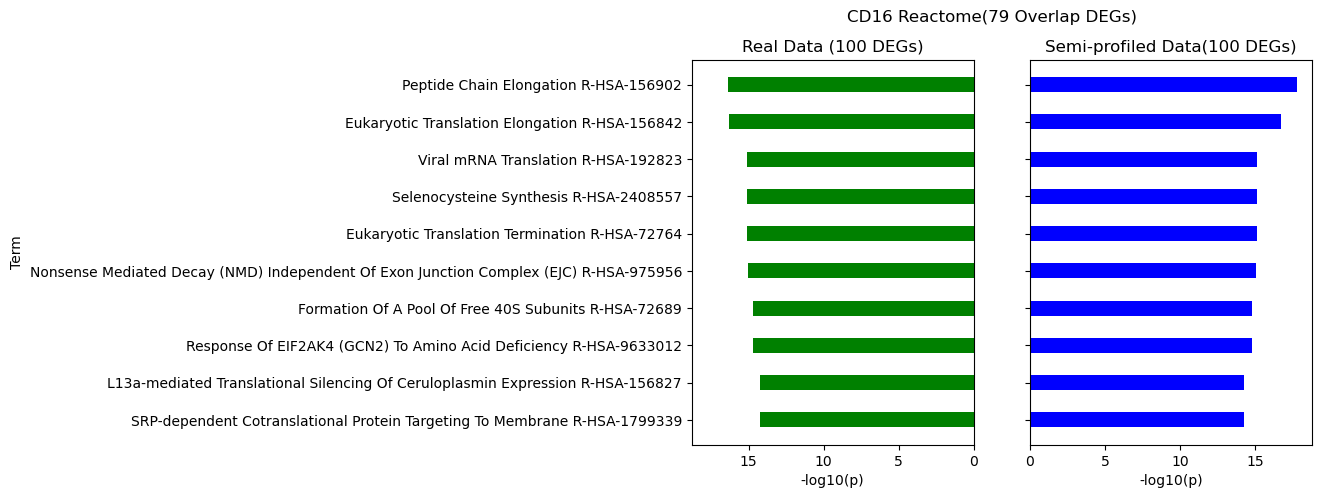

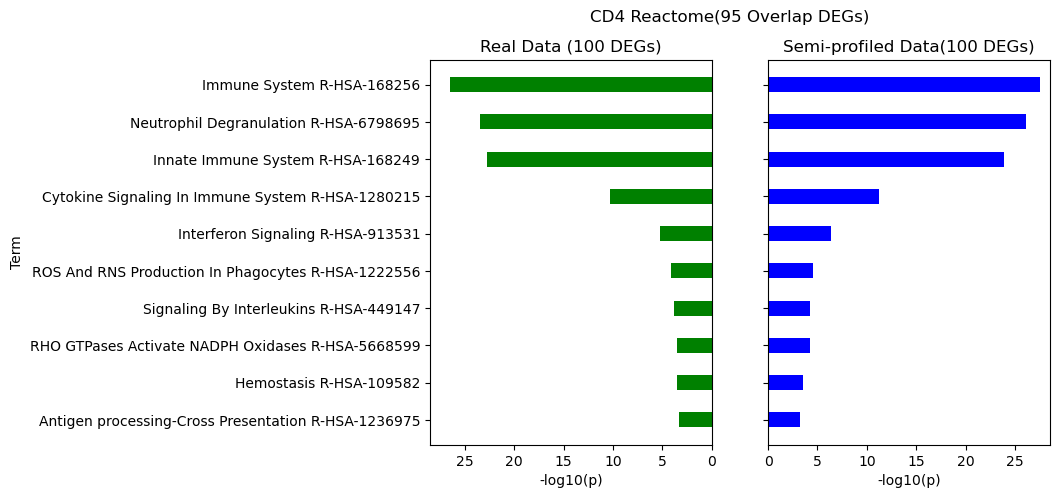

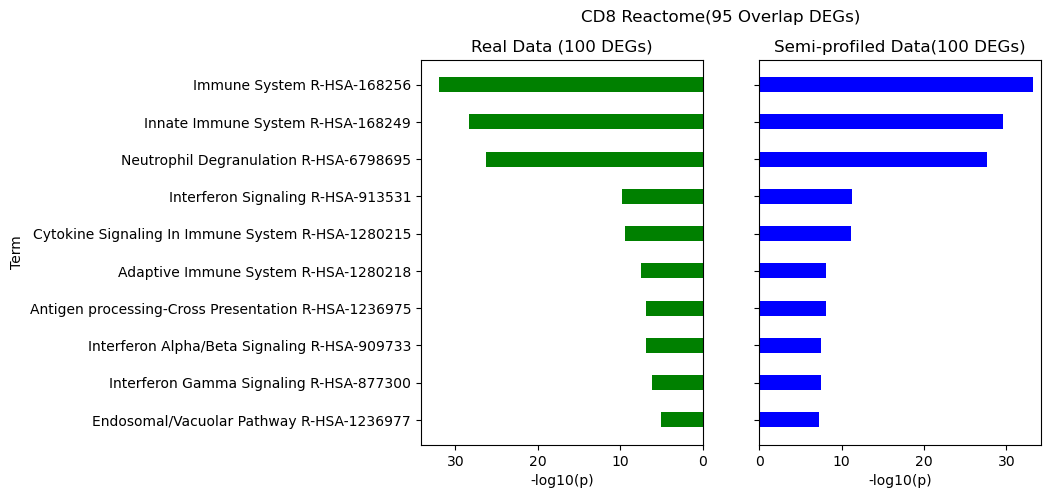

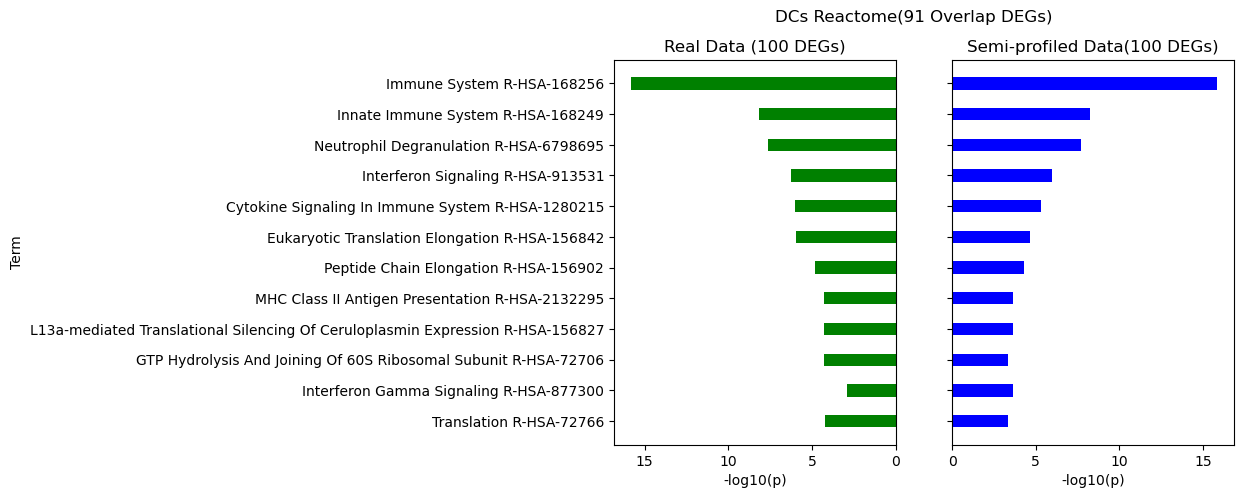

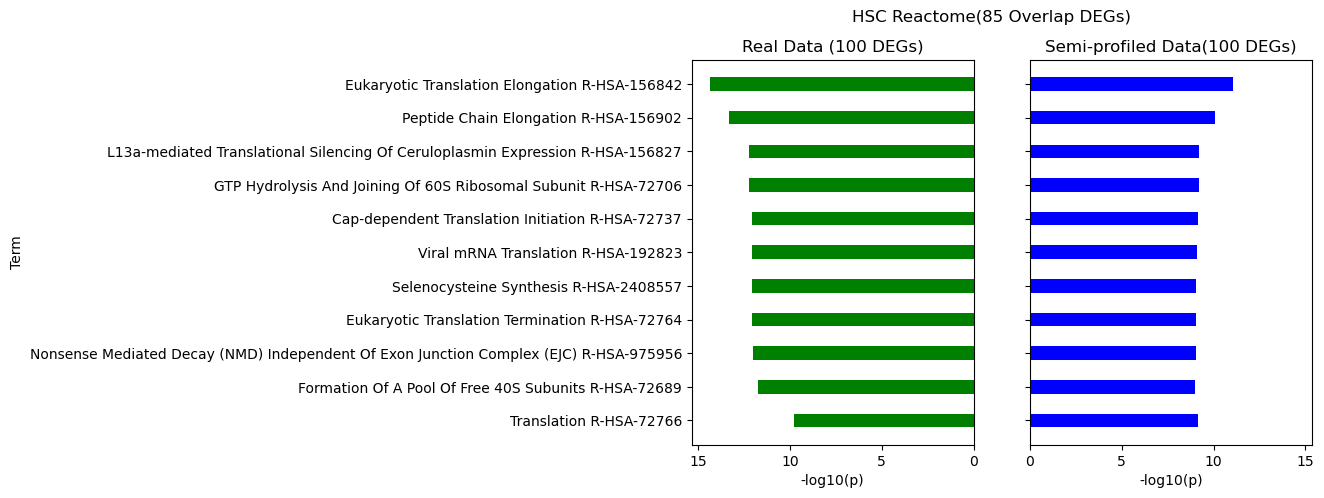

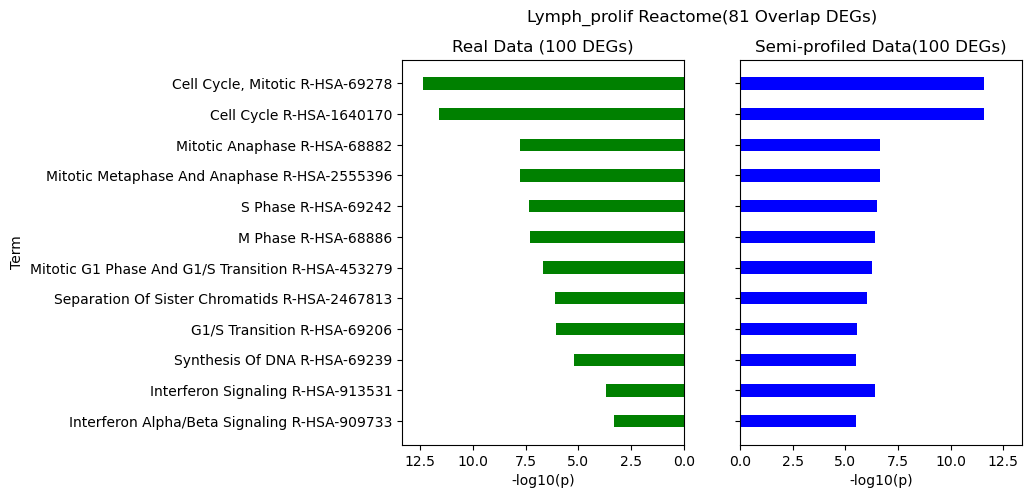

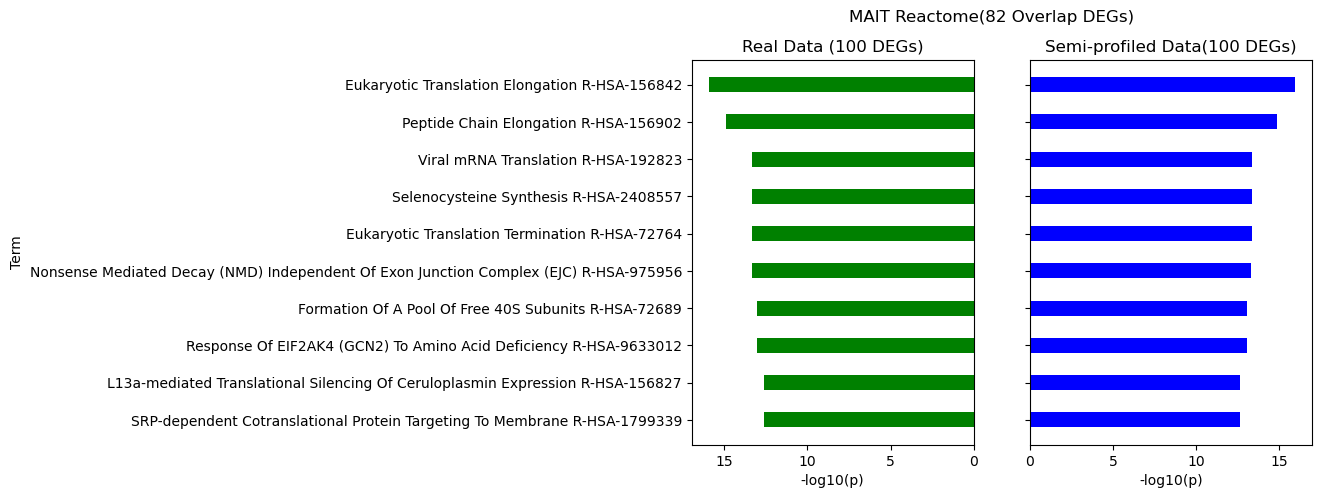

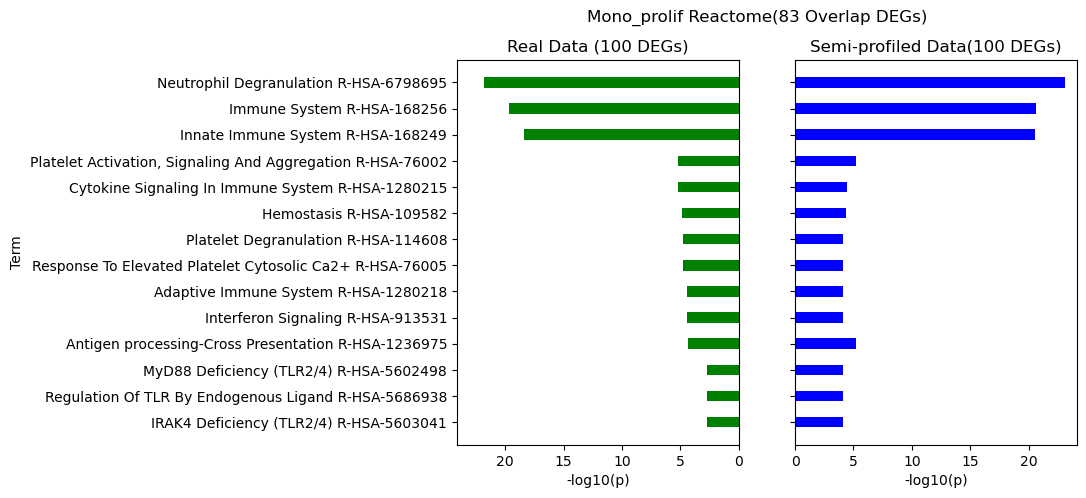

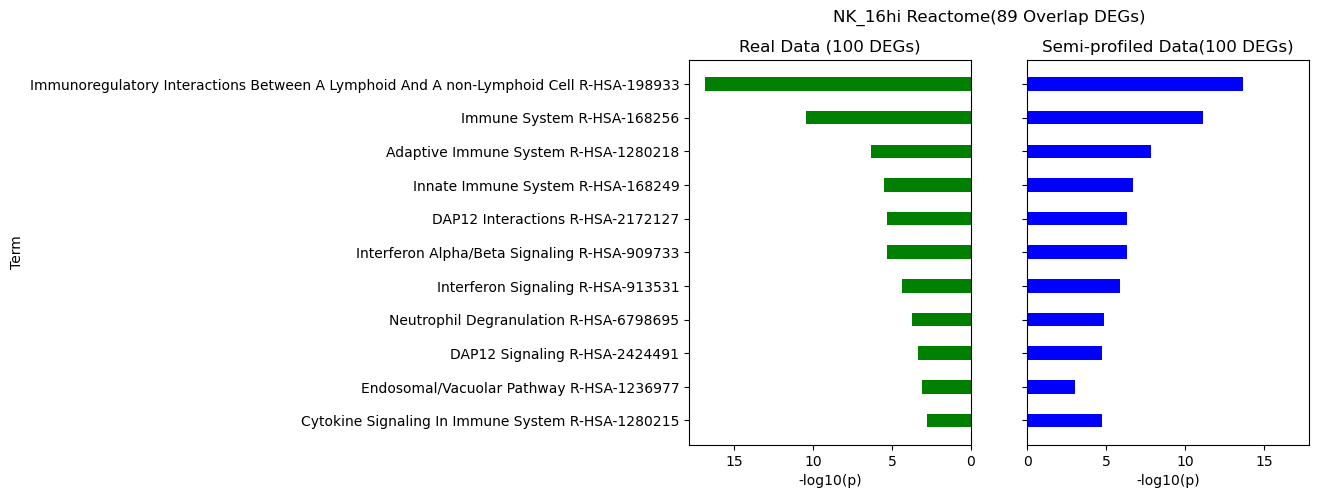

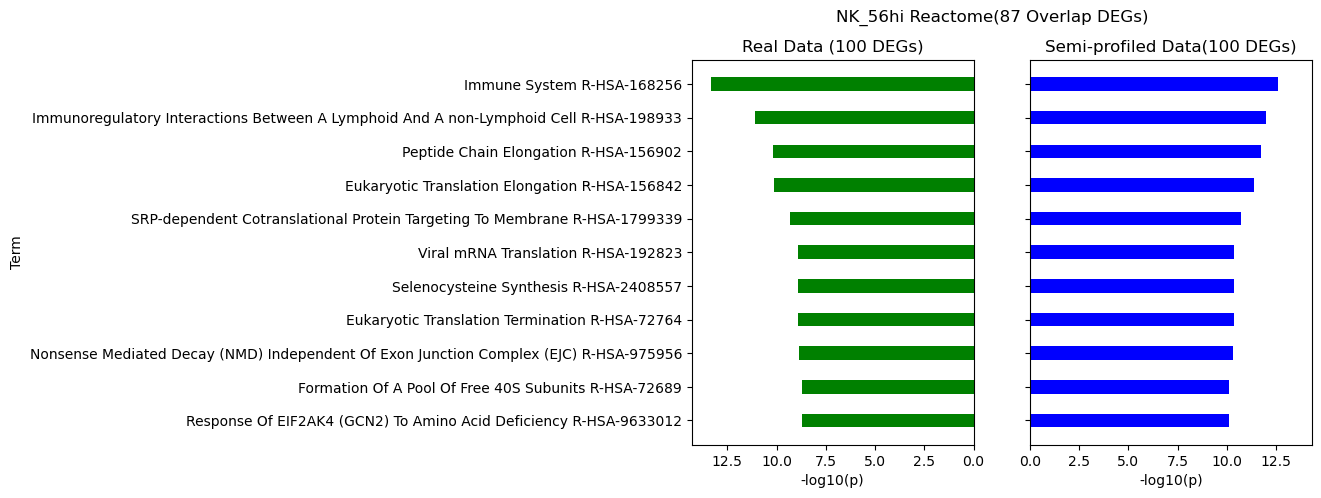

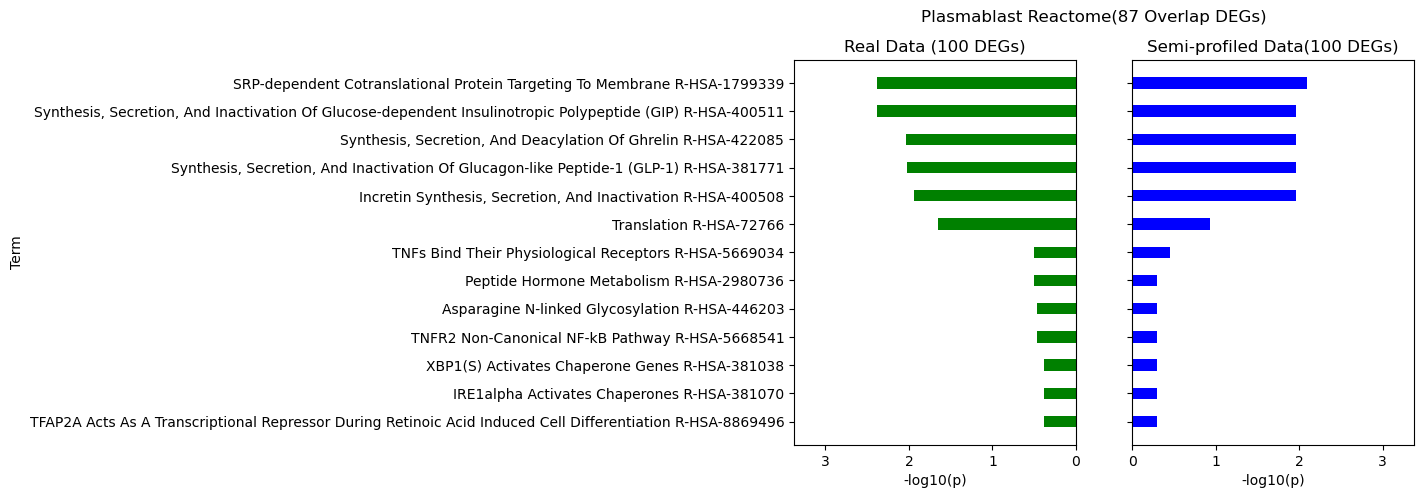

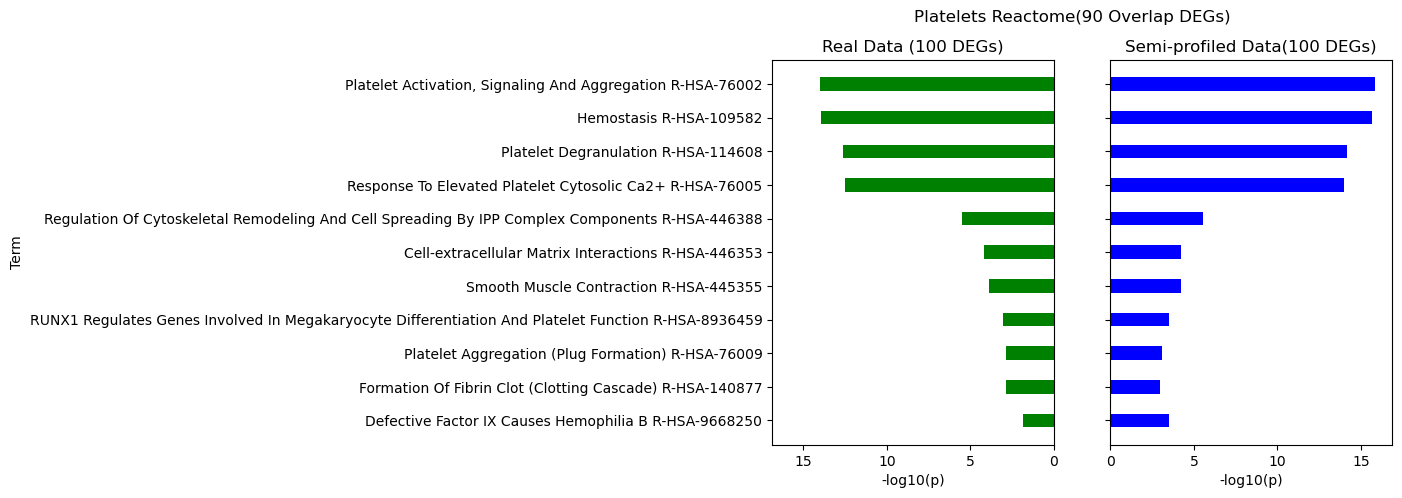

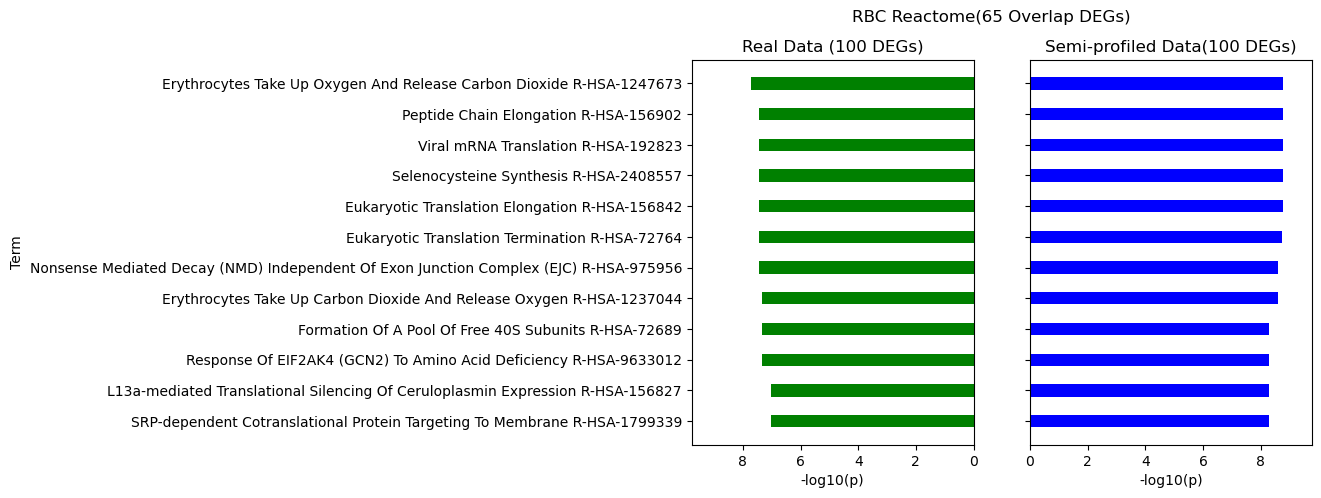

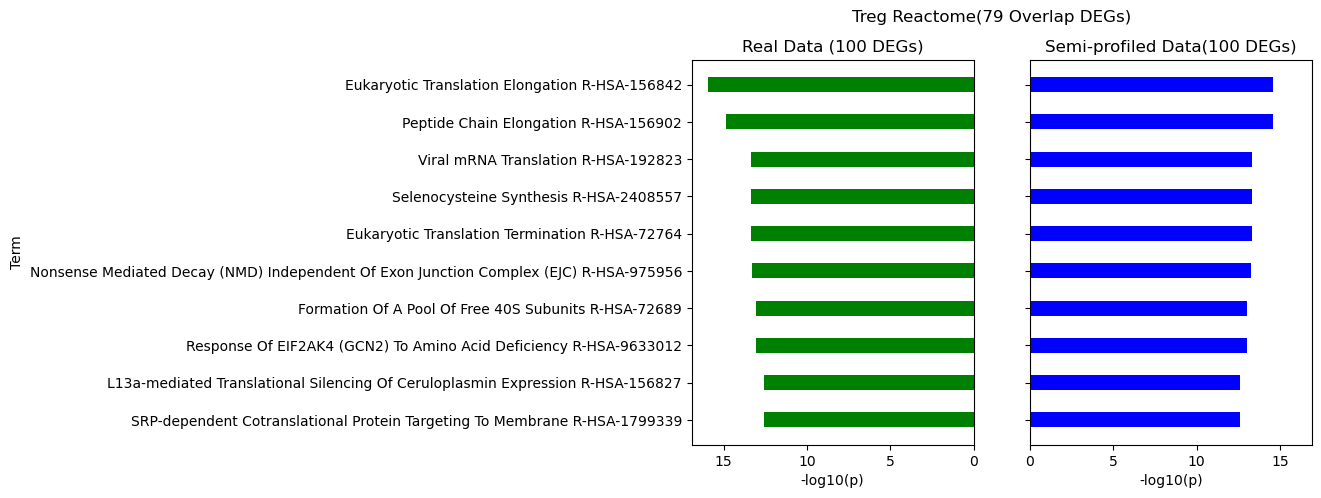

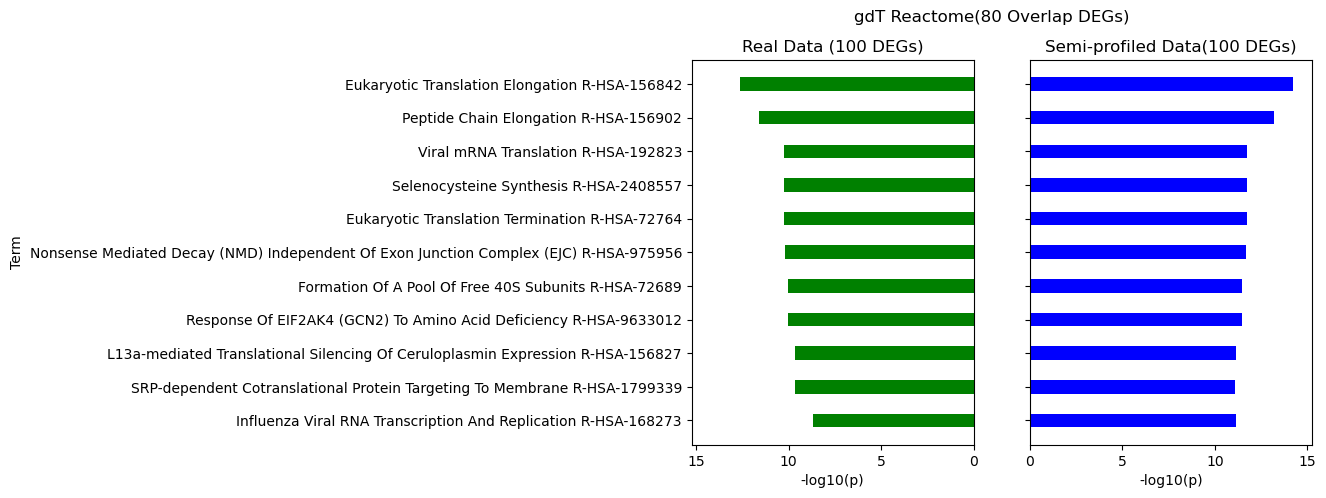

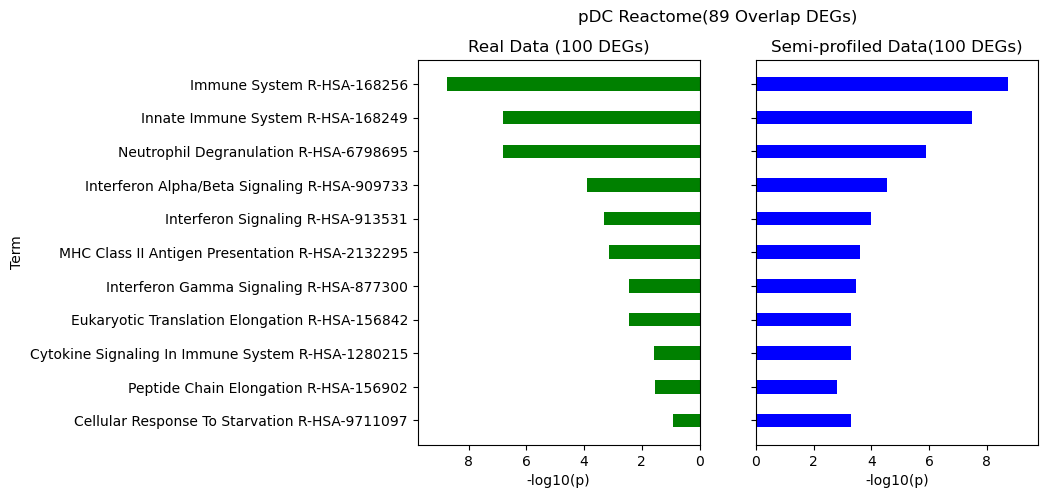

In [17]:

for j in range(0,totaltypes.shape[0]):
    selectedtype = totaltypes[j]
    c=0
    gtdeg = typededic[totaltypes[j]]
    semideg = semitypededic[totaltypes[j]]
    for i in semideg:
        if i in gtdeg:
            c+=1
            
            
    hyperpval = hypert(semisdata.X.shape[1],100,100,c)
    
    

    results = gseapy.enrichr(gene_list=gtdeg, gene_sets='Reactome_2022',outdir='gseapygt')
    f=open('gseapygt/Reactome_2022.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()

    gtsets=[]
    gtps=[]
    gtdic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        gtsets.append(term)
        gtps.append(p)
        gtdic[term] = p

    results = gseapy.enrichr(gene_list=semideg, gene_sets='Reactome_2022',outdir='gseapysemi')

    f=open('gseapysemi/Reactome_2022.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()
    semisets=[]
    semips=[]
    semidic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        semisets.append(term)
        semips.append(p)
        semidic[term]=p
    terms = copy.deepcopy(gtsets[:10])
    real_data = copy.deepcopy(gtps[:10])
    sim_data = []
    for i in range(10):
        gtterm = semisets[i]
        if gtterm not in semidic.keys():
            sim_data.append(1)
        else:
            sim_data.append(semidic[gtterm])


    for i in range(10):
        if semisets[i] in terms:
            continue
        terms.append(semisets[i])
        sim_data.append(semips[i])
        if semisets[i] not in gtdic.keys():
            real_data.append(1)
        else:
            real_data.append(gtdic[semisets[i]])
    real_data = np.flip(real_data)
    sim_data = np.flip(sim_data)
    terms = np.flip(terms)
    sim_bar_lengths = [-np.log10(p) for p in sim_data]
    real_bar_lengths = [-np.log10(p) for p in real_data]
    
    
    
    
    np.save('results/celltype_marker_reactome/' + selectedtype + '_pvals.npy',np.concatenate([(real_data).reshape((-1,1)),(sim_data).reshape((-1,1))],axis=1))
    
    res = scipy.stats.pearsonr(np.array(sim_bar_lengths),np.array(real_bar_lengths))
    f=open('results/celltype_marker_reactome/'+str(totaltypes[j])+'.txt','w')
    f.write('semi: '+str(len(semideg))+'\n')
    f.write('gt: '+str(len(gtdeg))+'\n')
    f.write('overlap: '+str(c)+'\n')
    f.write('pval:' + str(float(hyperpval))+'\n')
    f.write('pcor:' + str(res[0])+'\n')
    f.write('pcor pval:' + str(res[1]))
    f.close()

    
    
    

    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
    bar_width = 0.4
    y = np.arange(len(sim_data))+1
    ax1.barh(y, real_bar_lengths, height=bar_width, color='green', label='Real')
    ax1.set_xlabel('-log10(p)')
    ax1.set_ylabel('Term')
    ax1.set_title('Real Data ('+str(len(semideg))+' DEGs)')
    ax2.barh(y, sim_bar_lengths, height=bar_width, color='blue', label='Simulated')
    ax2.set_xlabel('-log10(p)')
    ax2.set_title('Semi-profiled Data('+str(len(gtdeg))+' DEGs)')
    max_val = max(max(sim_bar_lengths), max(real_bar_lengths))
    ax1.set_xlim(0,max_val + 1)
    ax2.set_xlim(0, max_val + 1)
    ax1.invert_xaxis()
    ax1.set_yticks(y)
    ax2.set_yticklabels(terms)
    fig.suptitle(selectedtype + ' Reactome('+str(c)+' Overlap DEGs)')
    plt.savefig('results/celltype_marker_reactome/'+selectedtype + ' Reactome.pdf',bbox_inches='tight')
    plt.savefig('results/celltype_marker_reactome/'+selectedtype + ' Reactome.png',dpi=600,bbox_inches='tight')
    plt.show()



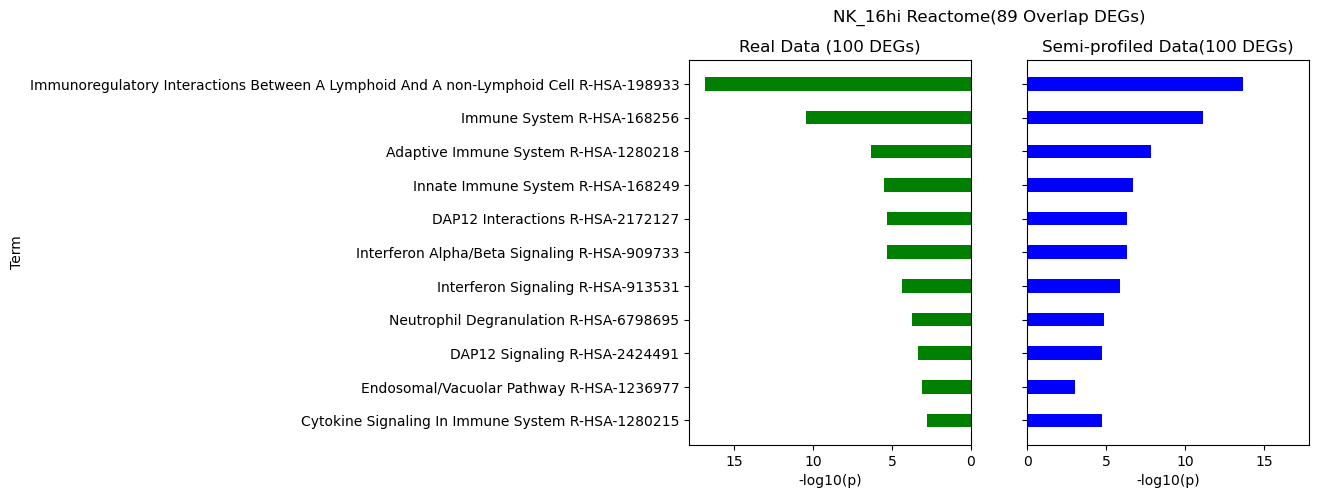

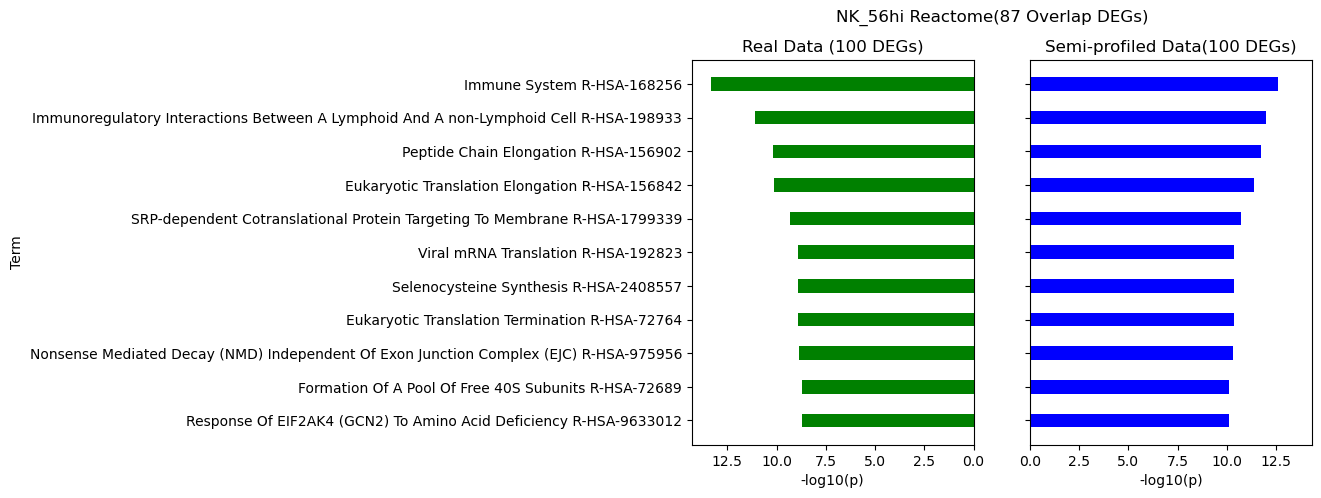

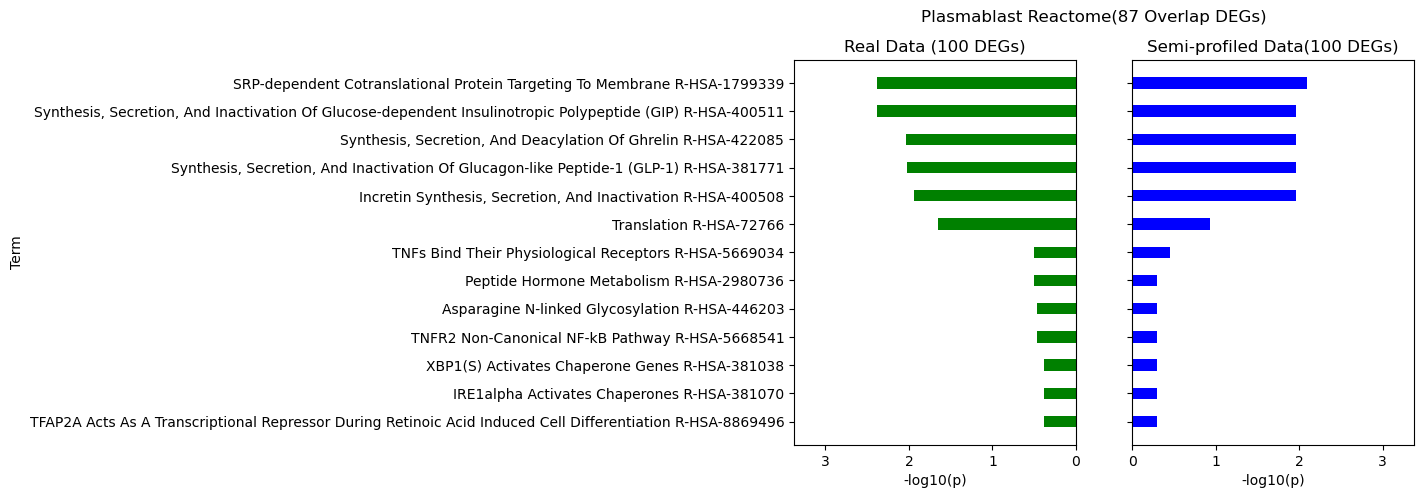

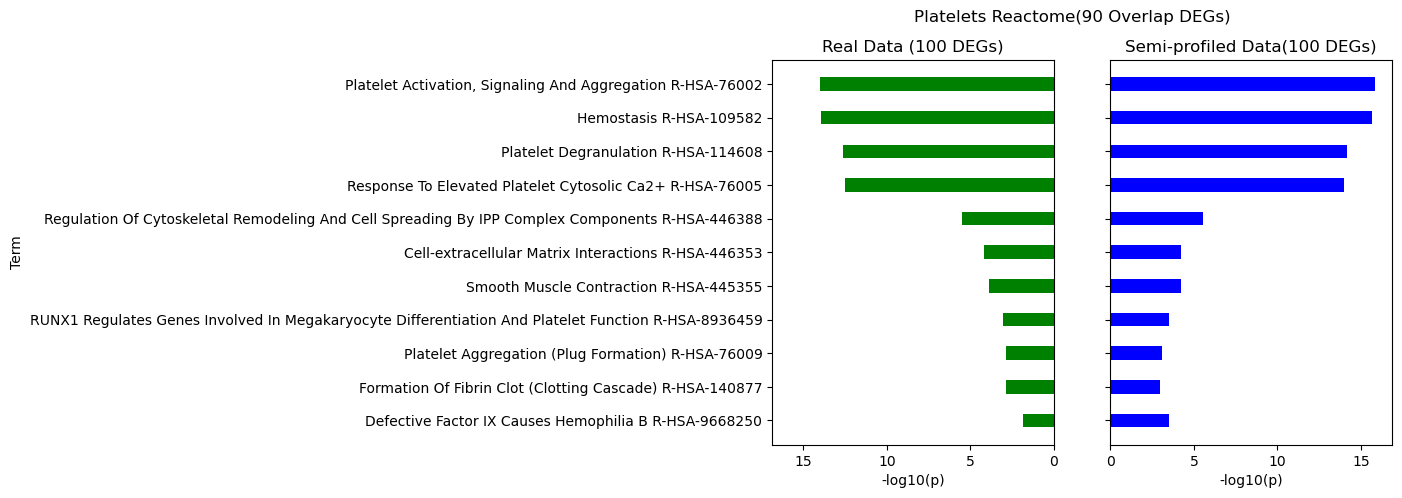

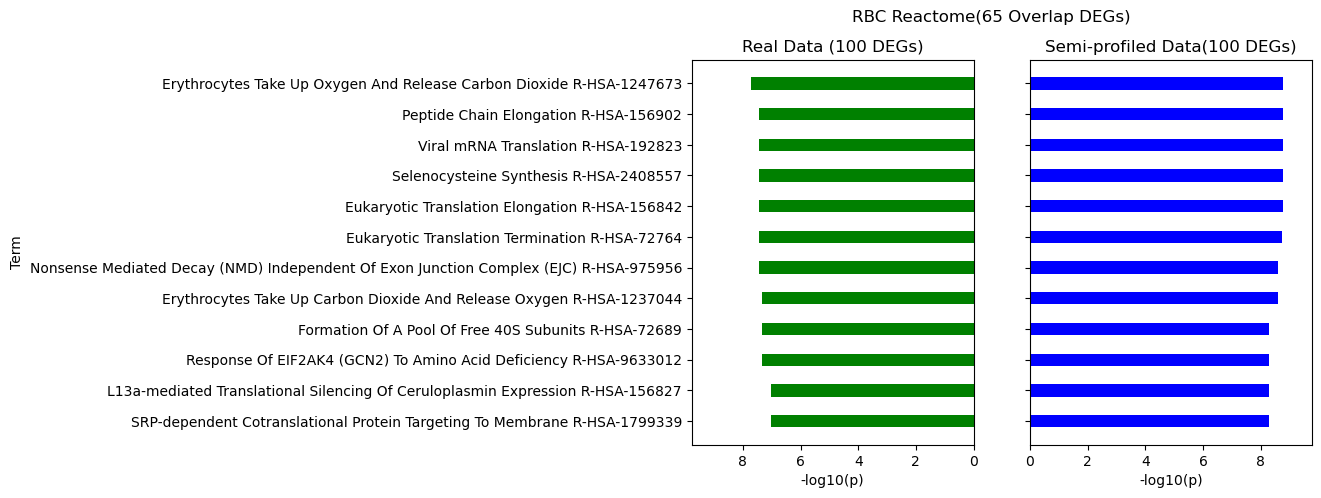

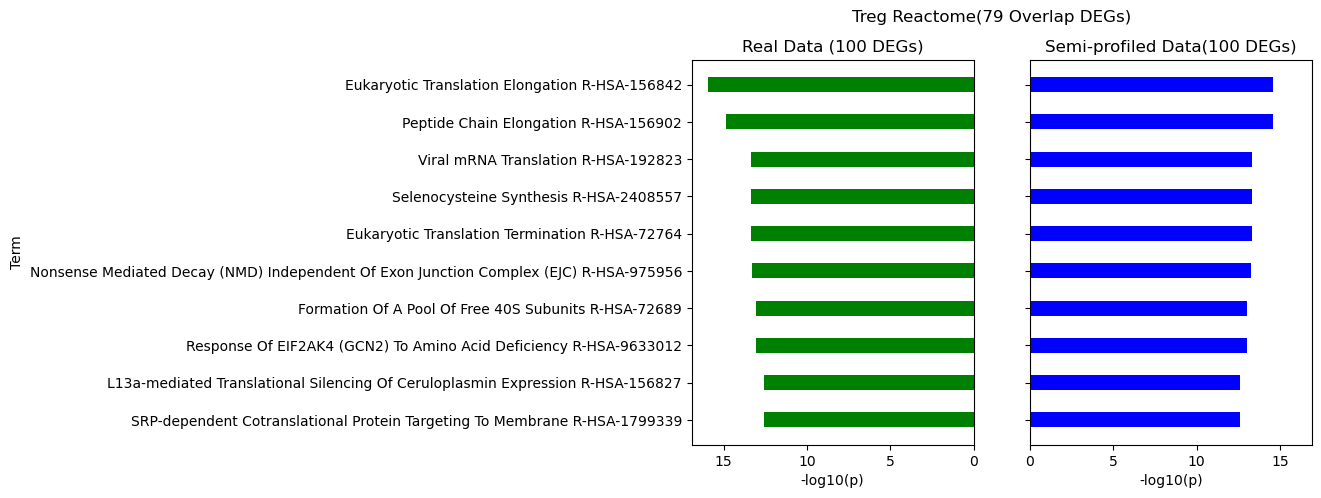

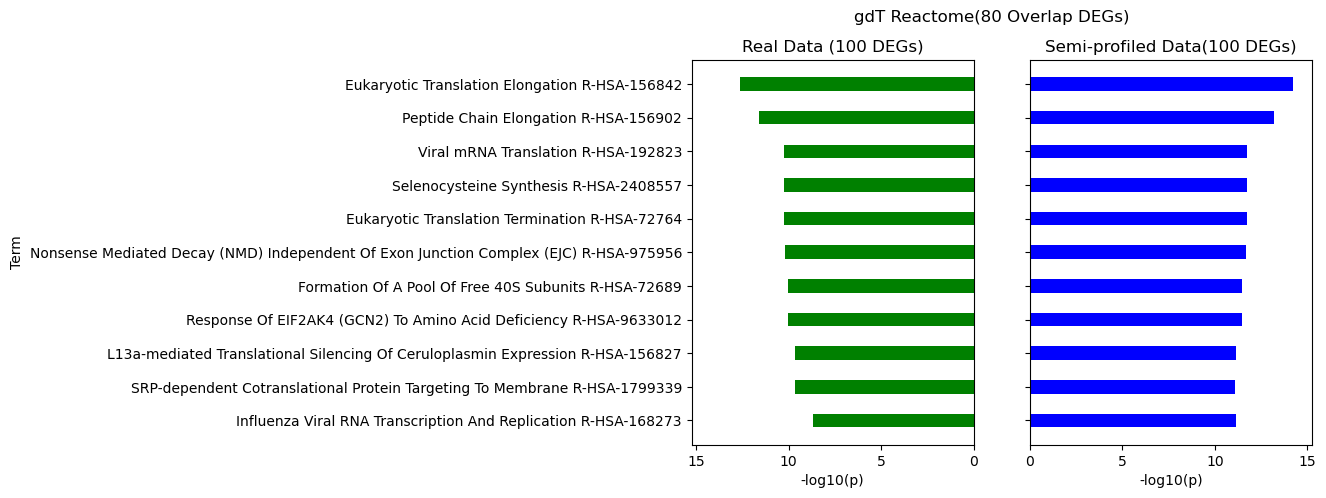

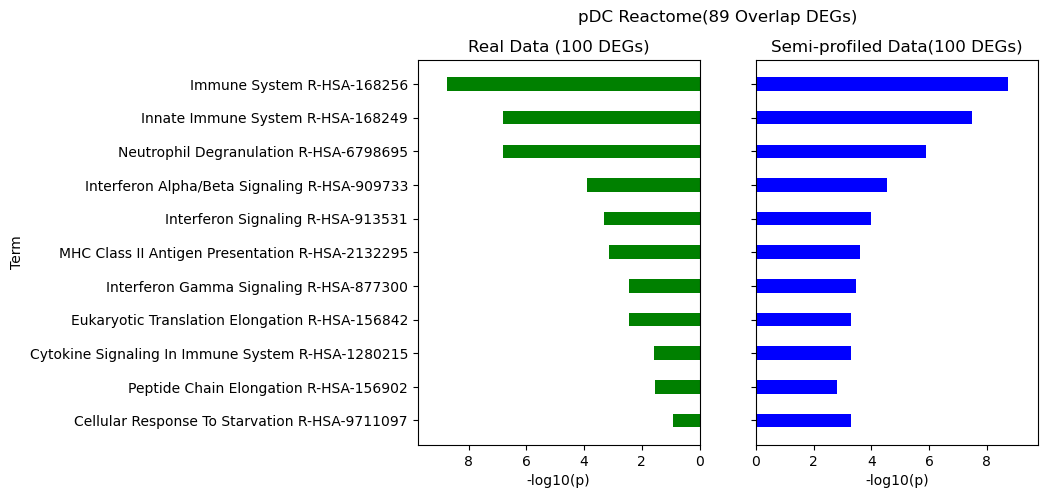

In [212]:


for j in range(10,totaltypes.shape[0]):
    selectedtype = totaltypes[j]
    c=0
    gtdeg = typededic[totaltypes[j]]
    semideg = semitypededic[totaltypes[j]]
    for i in semideg:
        if i in gtdeg:
            c+=1
    f=open('results/celltype_markers/'+str(totaltypes[j])+'.txt','w')
    f.write('semi: '+str(len(semideg))+'\n')
    f.write('gt: '+str(len(gtdeg))+'\n')
    f.write('overlap: '+str(c)+'\n')
    f.close()

    results = gseapy.enrichr(gene_list=gtdeg, gene_sets='Reactome_2022',outdir='gseapygt')
    f=open('gseapygt/Reactome_2022.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()

    gtsets=[]
    gtps=[]
    gtdic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        gtsets.append(term)
        gtps.append(p)
        gtdic[term] = p

    results = gseapy.enrichr(gene_list=semideg, gene_sets='Reactome_2022',outdir='gseapysemi')

    f=open('gseapysemi/Reactome_2022.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()
    semisets=[]
    semips=[]
    semidic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        semisets.append(term)
        semips.append(p)
        semidic[term]=p
    terms = copy.deepcopy(gtsets[:10])
    real_data = copy.deepcopy(gtps[:10])
    sim_data = []
    for i in range(10):
        gtterm = semisets[i]
        if gtterm not in semidic.keys():
            sim_data.append(1)
        else:
            sim_data.append(semidic[gtterm])


    for i in range(10):
        if semisets[i] in terms:
            continue
        terms.append(semisets[i])
        sim_data.append(semips[i])
        if semisets[i] not in gtdic.keys():
            real_data.append(1)
        else:
            real_data.append(gtdic[semisets[i]])
    real_data = np.flip(real_data)
    sim_data = np.flip(sim_data)
    terms = np.flip(terms)
    sim_bar_lengths = [-np.log10(p) for p in sim_data]
    real_bar_lengths = [-np.log10(p) for p in real_data]
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
    bar_width = 0.4
    y = np.arange(len(sim_data))+1
    ax1.barh(y, real_bar_lengths, height=bar_width, color='green', label='Real')
    ax1.set_xlabel('-log10(p)')
    ax1.set_ylabel('Term')
    ax1.set_title('Real Data ('+str(len(semideg))+' DEGs)')
    ax2.barh(y, sim_bar_lengths, height=bar_width, color='blue', label='Simulated')
    ax2.set_xlabel('-log10(p)')
    ax2.set_title('Semi-profiled Data('+str(len(gtdeg))+' DEGs)')
    max_val = max(max(sim_bar_lengths), max(real_bar_lengths))
    ax1.set_xlim(0,max_val + 1)
    ax2.set_xlim(0, max_val + 1)
    ax1.invert_xaxis()
    ax1.set_yticks(y)
    ax2.set_yticklabels(terms)
    fig.suptitle(selectedtype + ' Reactome('+str(c)+' Overlap DEGs)')
    plt.savefig('results/celltype_markers/'+selectedtype + ' Reactome.pdf',bbox_inches='tight')
    plt.savefig('results/celltype_markers/'+selectedtype + ' Reactome.png',dpi=600,bbox_inches='tight')
    plt.show()

In [8]:


### GO Bio Process


sc.tl.rank_genes_groups(gtdata, 'celltypes', method='t-test')
#sc.pl.rank_genes_groups(gtdata, n_genes=50, sharey=False)



NameError: name 'totaltypes' is not defined

In [9]:
totaltypes = np.unique(gtdata.obs['celltypes'])

In [10]:
typededic = {}
for j in range(totaltypes.shape[0]):
    celltype = totaltypes[j]
    typede = []
    for i in range(100):
        g = gtdata.uns['rank_genes_groups']['names'][i][j]
        typede.append(g)
        
    typededic[celltype] = typede



sc.tl.rank_genes_groups(semisdata, 'celltypes', method='t-test')

semitypededic = {}
for j in range(totaltypes.shape[0]):
    celltype = totaltypes[j]
    typede = []
    for i in range(100):
        g = semisdata.uns['rank_genes_groups']['names'][i][j]
        typede.append(g)
        
    semitypededic[celltype] = typede


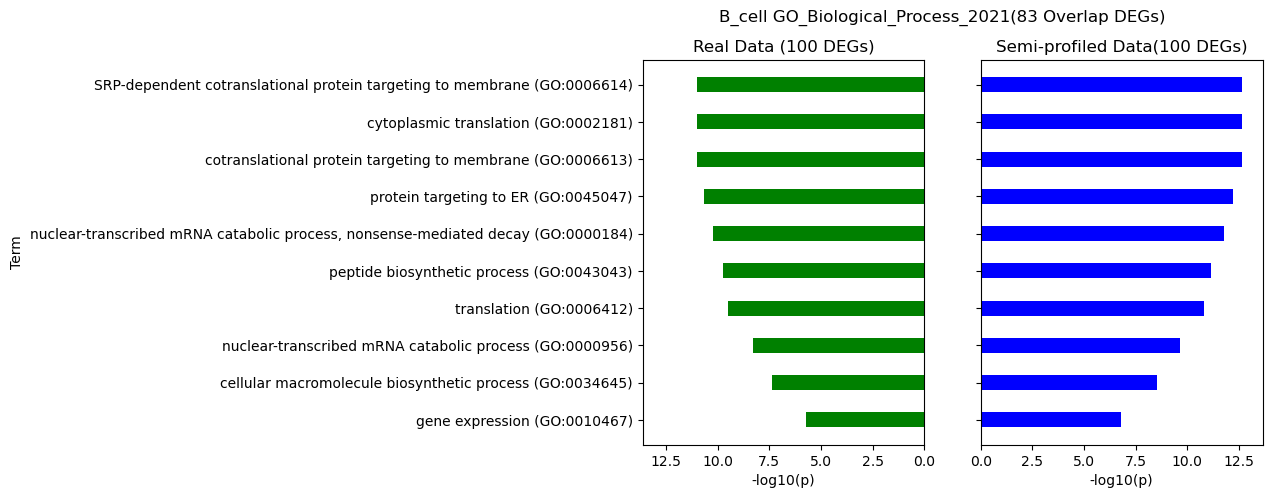

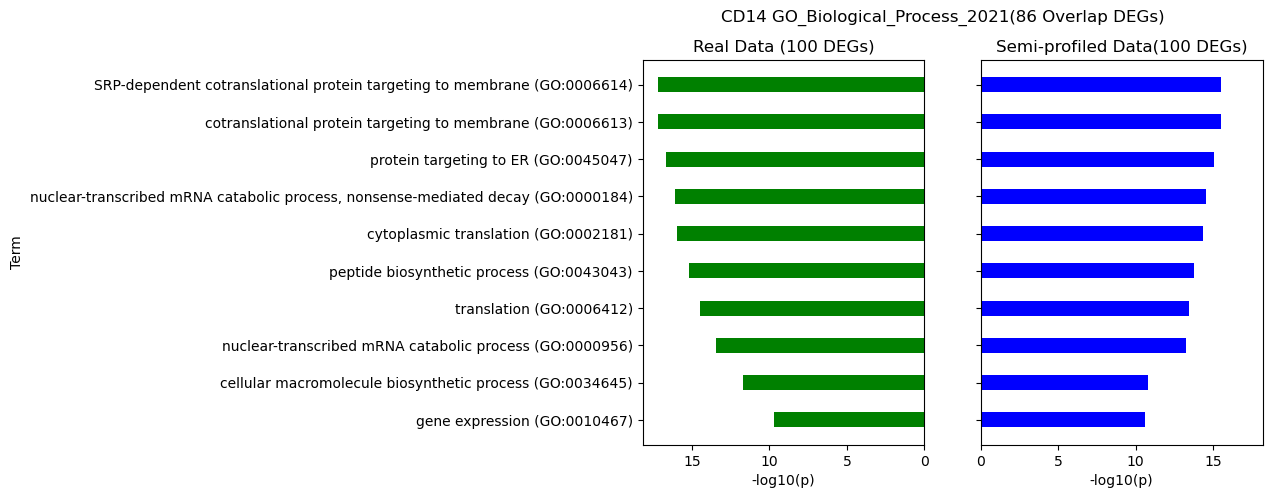

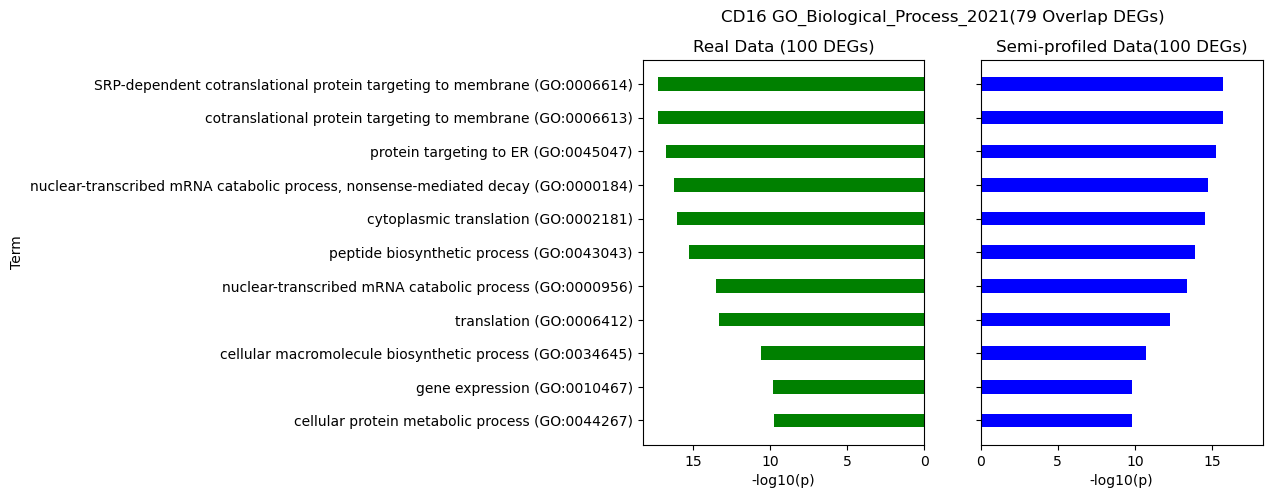

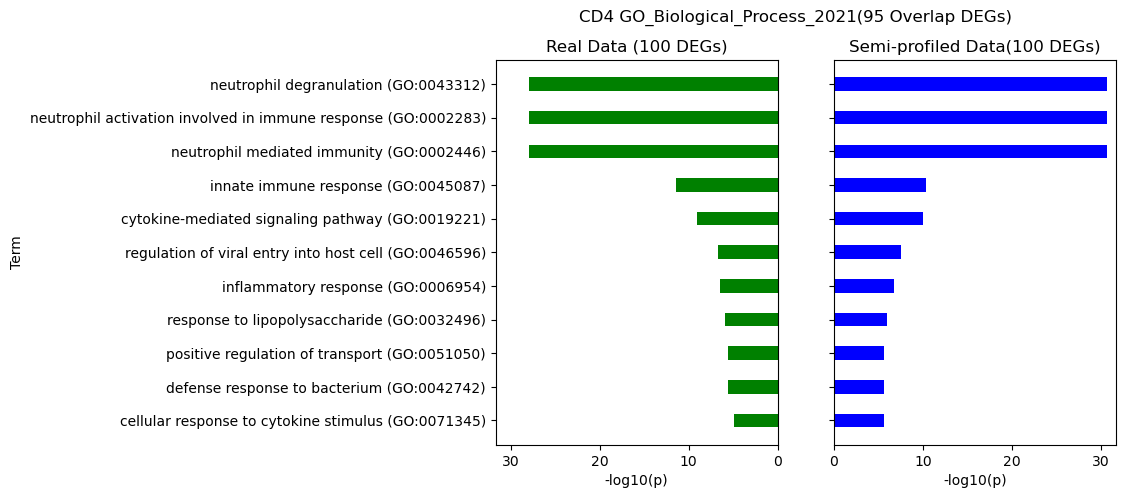

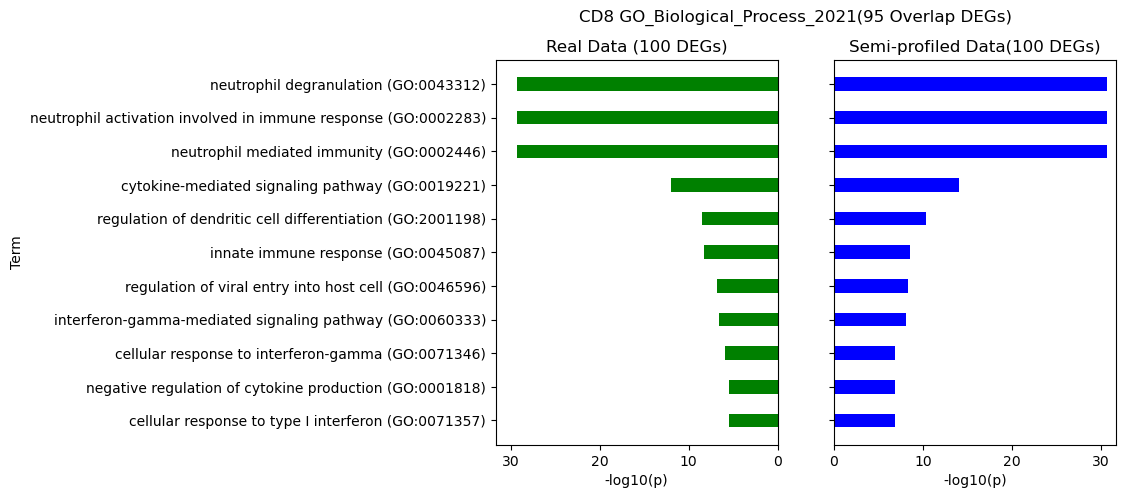

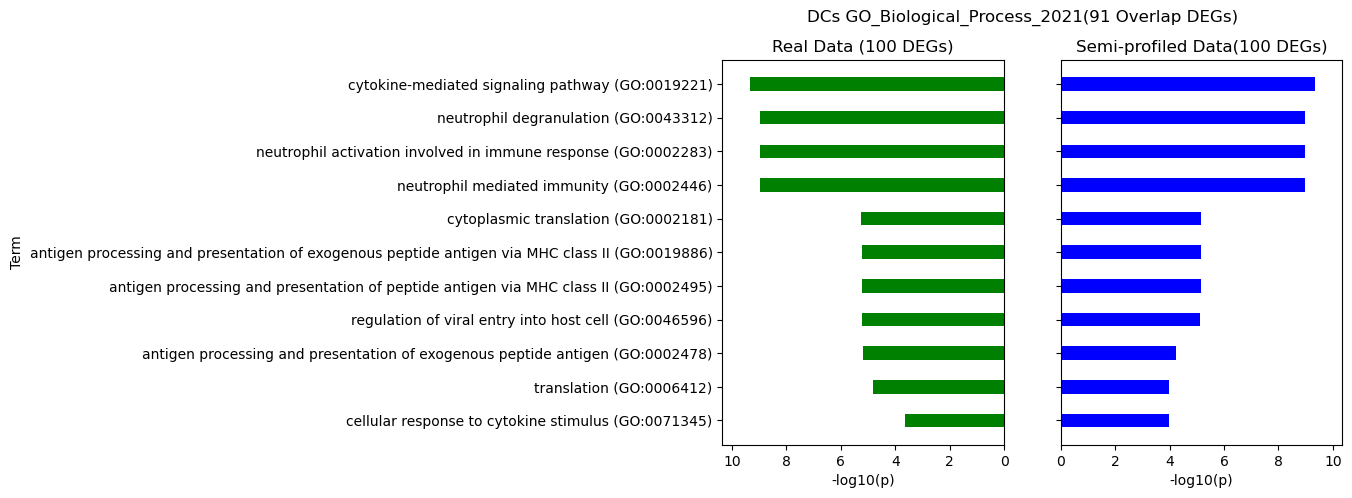

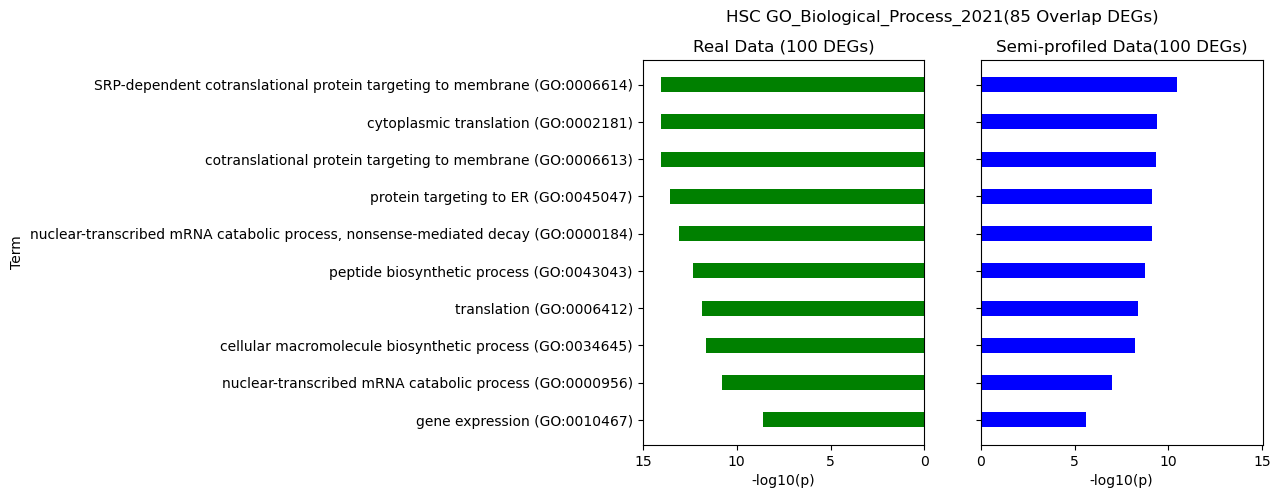

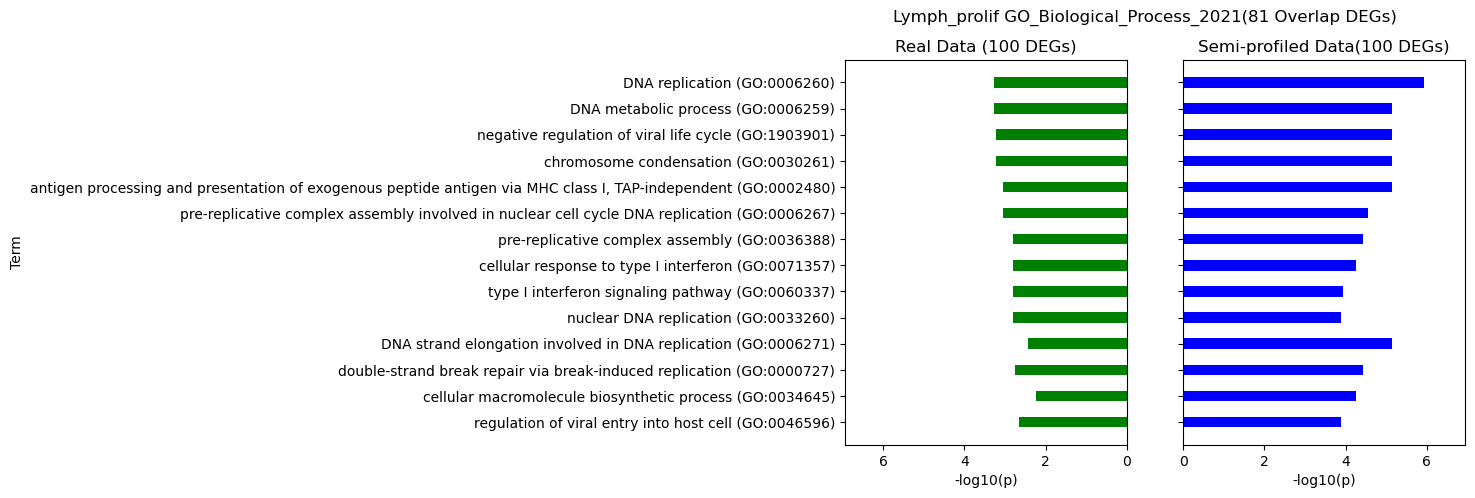

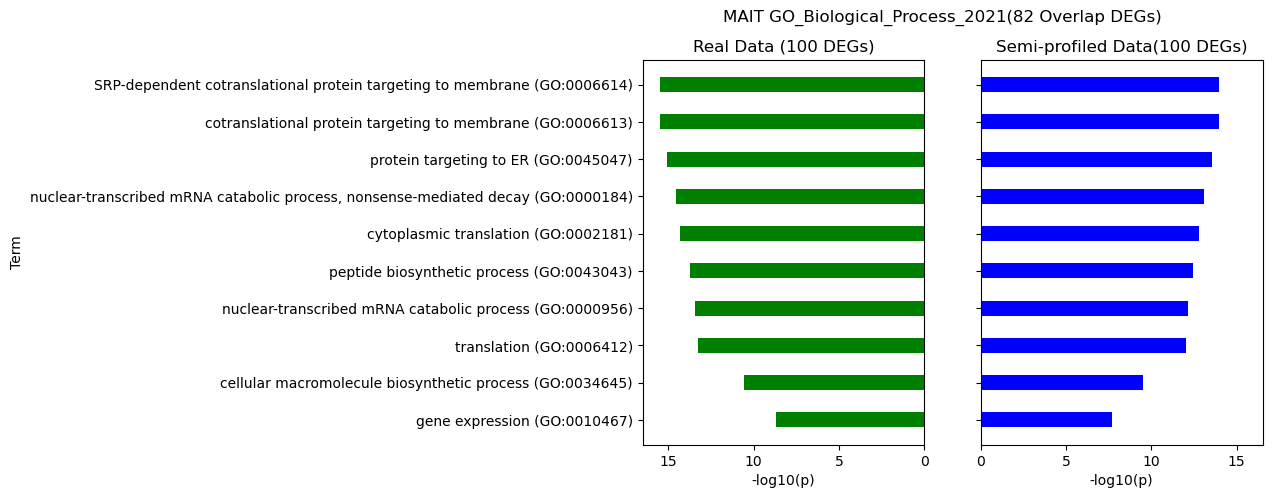

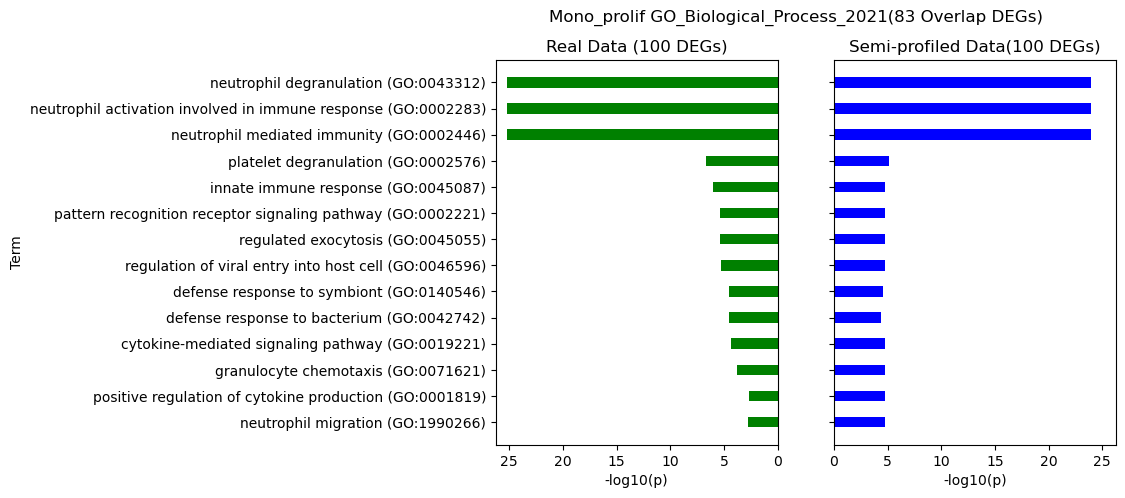

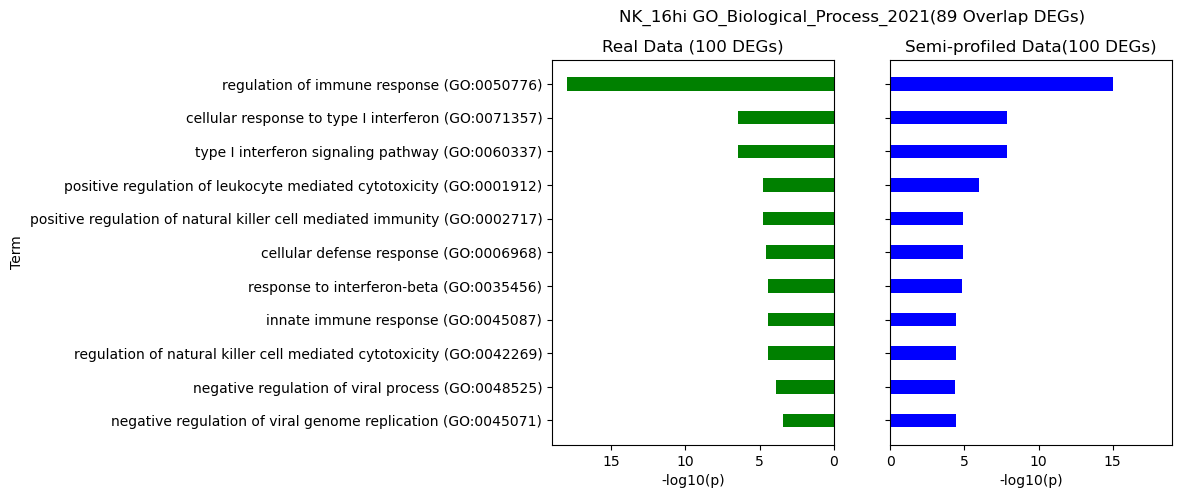

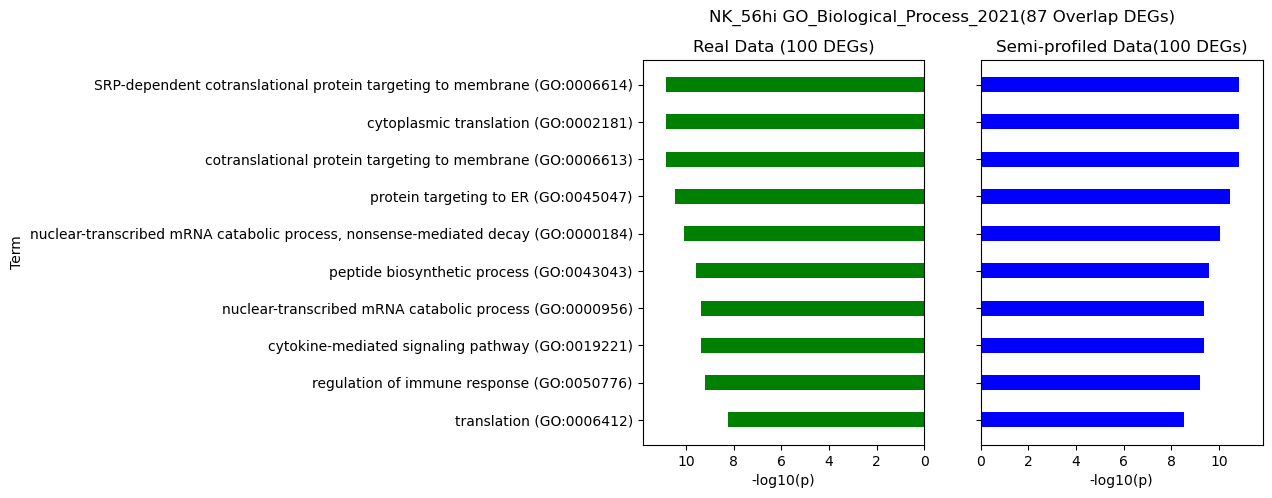

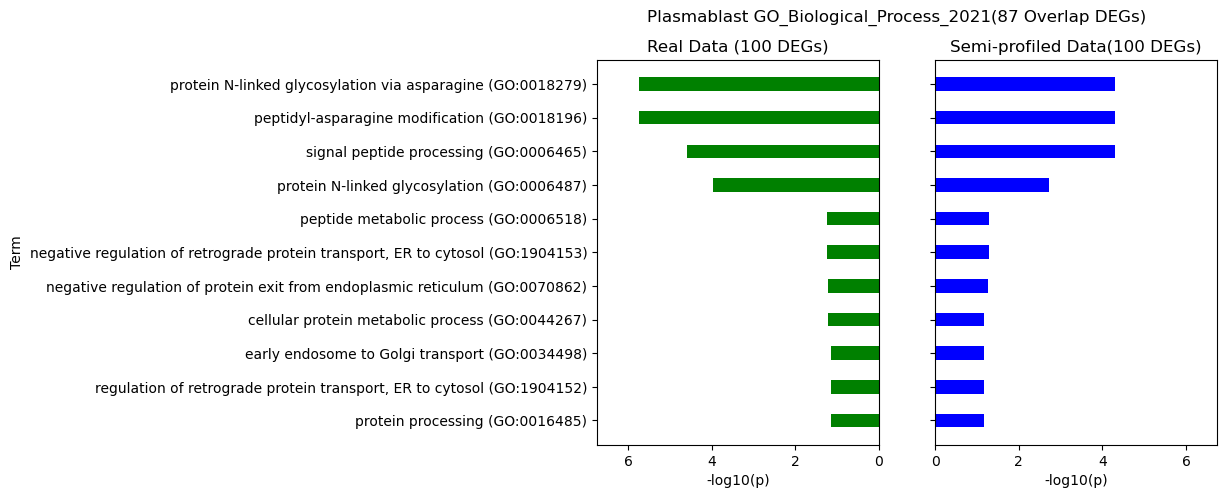

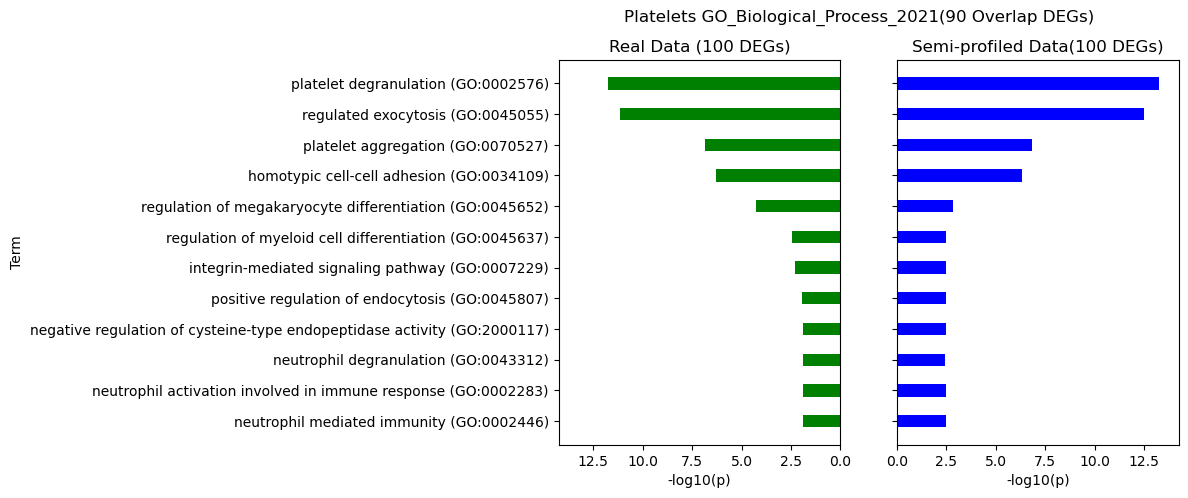

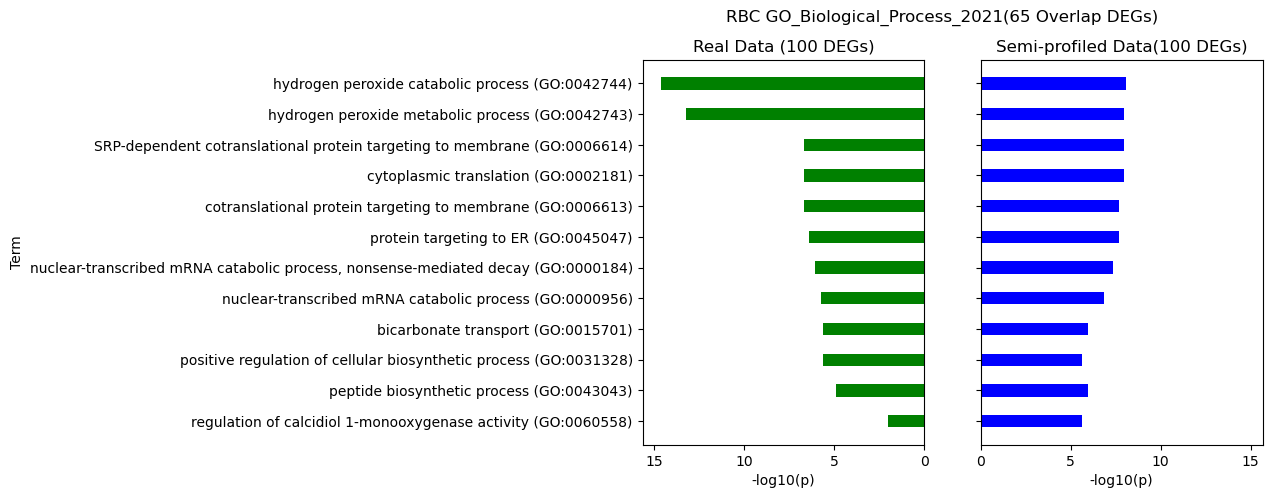

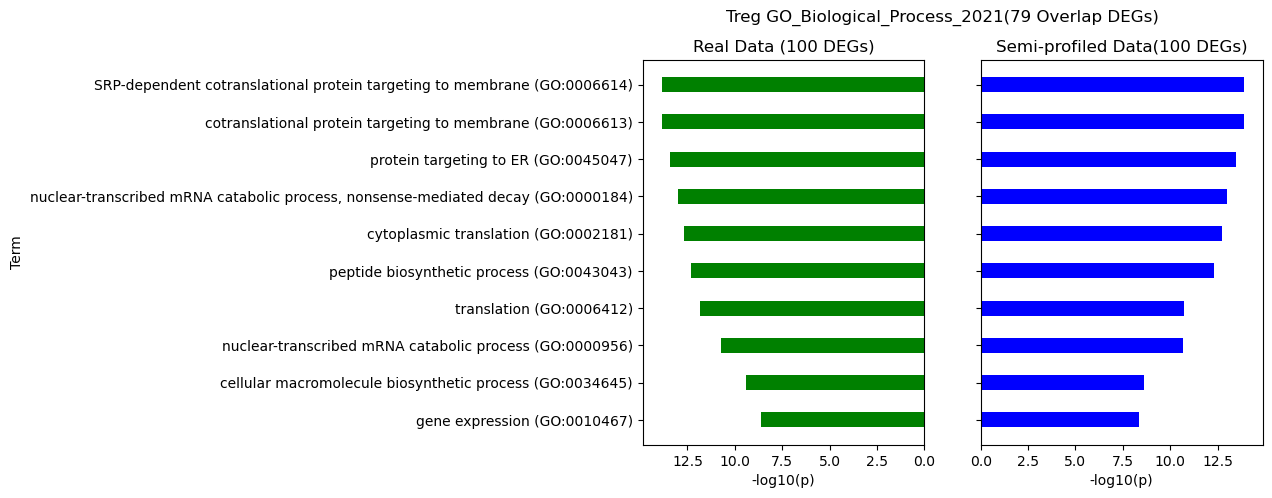

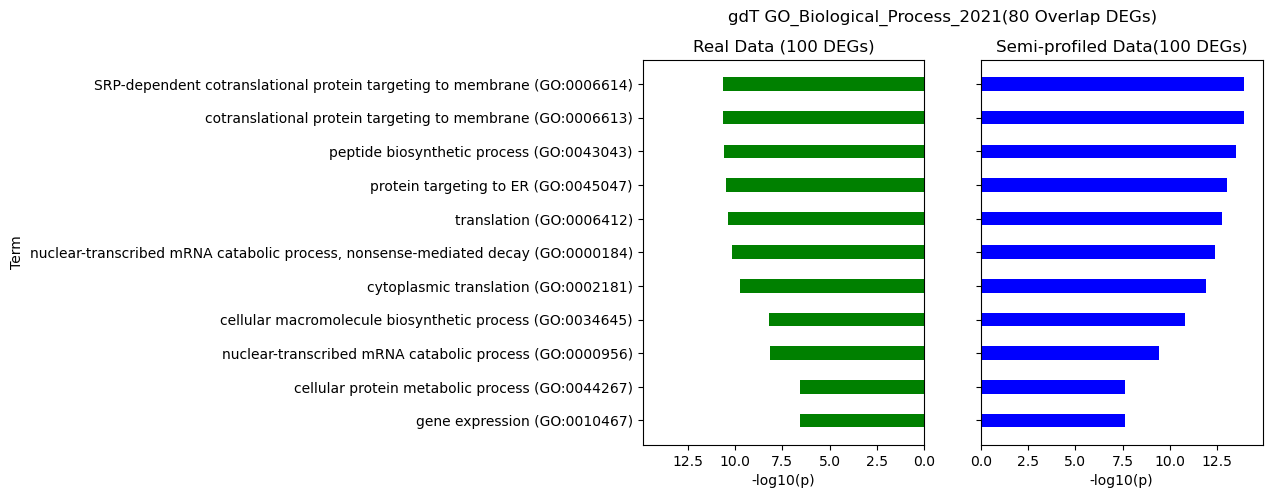

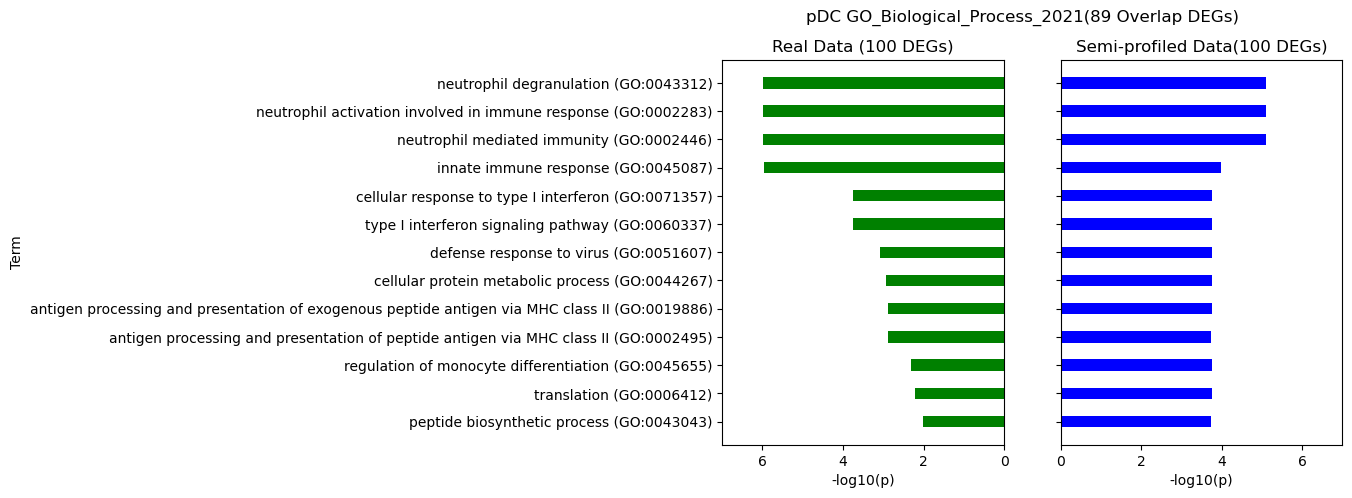

In [11]:

for j in range(0,totaltypes.shape[0]):
    c=0
    selectedtype = totaltypes[j]
    gtdeg = typededic[totaltypes[j]]
    semideg = semitypededic[totaltypes[j]]
    for i in semideg:
        if i in gtdeg:
            c+=1
            
            
    hyperpval = hypert(semisdata.X.shape[1],100,100,c)
            
    

    results = gseapy.enrichr(gene_list=gtdeg, gene_sets='GO_Biological_Process_2021',outdir='gseapygt')
    f=open('gseapygt/GO_Biological_Process_2021.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()

    gtsets=[]
    gtps=[]
    gtdic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        gtsets.append(term)
        gtps.append(p)
        gtdic[term] = p

    results = gseapy.enrichr(gene_list=semideg, gene_sets='GO_Biological_Process_2021',outdir='gseapysemi')

    f=open('gseapysemi/GO_Biological_Process_2021.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()
    semisets=[]
    semips=[]
    semidic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        semisets.append(term)
        semips.append(p)
        semidic[term]=p
    terms = copy.deepcopy(gtsets[:10])
    real_data = copy.deepcopy(gtps[:10])
    sim_data = []
    for i in range(10):
        gtterm = semisets[i]
        if gtterm not in semidic.keys():
            sim_data.append(1)
        else:
            sim_data.append(semidic[gtterm])


    for i in range(10):
        if semisets[i] in terms:
            continue
        terms.append(semisets[i])
        sim_data.append(semips[i])
        if semisets[i] not in gtdic.keys():
            real_data.append(1)
        else:
            real_data.append(gtdic[semisets[i]])
    real_data = np.flip(real_data)
    sim_data = np.flip(sim_data)
    terms = np.flip(terms)
    sim_bar_lengths = [-np.log10(p) for p in sim_data]
    real_bar_lengths = [-np.log10(p) for p in real_data]
    
    
    np.save('results/celltype_marker_go/' + selectedtype + '_pvals.npy',np.concatenate([(real_data).reshape((-1,1)),(sim_data).reshape((-1,1))],axis=1))
    
    res = scipy.stats.pearsonr(np.array(sim_bar_lengths),np.array(real_bar_lengths))
    f=open('results/celltype_marker_go/'+str(totaltypes[j])+'.txt','w')
    f.write('semi: '+str(len(semideg))+'\n')
    f.write('gt: '+str(len(gtdeg))+'\n')
    f.write('overlap: '+str(c)+'\n')
    f.write('pval:' + str(float(hyperpval))+'\n')
    f.write('pcor:' + str(res[0])+'\n')
    f.write('pcor pval:' + str(res[1]))
    f.close()

    
    
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
    bar_width = 0.4
    y = np.arange(len(sim_data))+1
    ax1.barh(y, real_bar_lengths, height=bar_width, color='green', label='Real')
    ax1.set_xlabel('-log10(p)')
    ax1.set_ylabel('Term')
    ax1.set_title('Real Data ('+str(len(semideg))+' DEGs)')
    ax2.barh(y, sim_bar_lengths, height=bar_width, color='blue', label='Simulated')
    ax2.set_xlabel('-log10(p)')
    ax2.set_title('Semi-profiled Data('+str(len(gtdeg))+' DEGs)')
    max_val = max(max(sim_bar_lengths), max(real_bar_lengths))
    ax1.set_xlim(0,max_val + 1)
    ax2.set_xlim(0, max_val + 1)
    ax1.invert_xaxis()
    ax1.set_yticks(y)
    ax2.set_yticklabels(terms)
    fig.suptitle(selectedtype + ' GO_Biological_Process_2021('+str(c)+' Overlap DEGs)')
    plt.savefig('results/celltype_marker_go/'+selectedtype + ' GO_Biological_Process_2021.pdf',bbox_inches='tight')
    plt.savefig('results/celltype_marker_go/'+selectedtype + ' GO_Biological_Process_2021.png',dpi=600,bbox_inches='tight')
    plt.show()

### End of Enrichment

In [8]:
semisdata

AnnData object with n_obs × n_vars = 665605 × 6030
    obs: 'status', 'status_collection', 'sampleids', 'repmask', 'IFN_score', 'initial_clustering', 'celltypes', 'states_collection_sum'
    var: 'feature_types'
    uns: 'celltypes_colors', 'celltypes_sizes', 'neighbors', 'paga', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_joint', 'X_umap'
    obsp: 'connectivities', 'distances'

In [9]:
gtdata

AnnData object with n_obs × n_vars = 637144 × 6030
    obs: 'status', 'status_collection', 'states_collection_sum', 'celltypes', 'subtypes', 'repmask', 'ft', 'IFN_score', 'sample_ids', 'sample_id', 'initial_clustering'
    var: 'feature_types'
    uns: 'celltypes_colors', 'celltypes_sizes', 'ft_colors', 'neighbors', 'paga', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_joint', 'X_umap'
    obsp: 'connectivities', 'distances'

## PAGA

In [216]:
sc.pp.neighbors(semisdata,use_rep='X_pca',n_neighbors=50)

In [217]:
sc.tl.paga(semisdata,groups = 'celltypes')

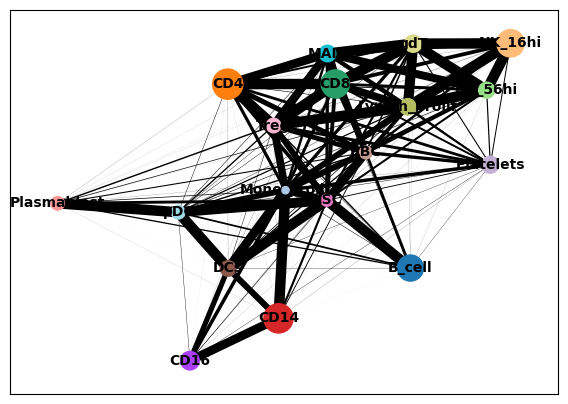

In [11]:
sc.pl.paga(semisdata, plot=True,threshold=0,save='semi_paga_threshold_threshold0_t10.pdf')

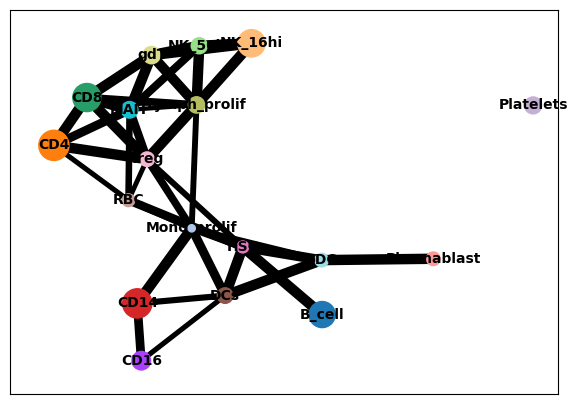

In [24]:
thr = 0.4
sc.pl.paga(semisdata, plot=True,threshold=thr,save='semi_paga_threshold_threshold'+str(thr)+'_t10.pdf')

In [219]:
sc.pp.neighbors(gtdata,use_rep='X_pca',n_neighbors=50)

In [220]:
sc.tl.paga(gtdata, groups = 'celltypes')

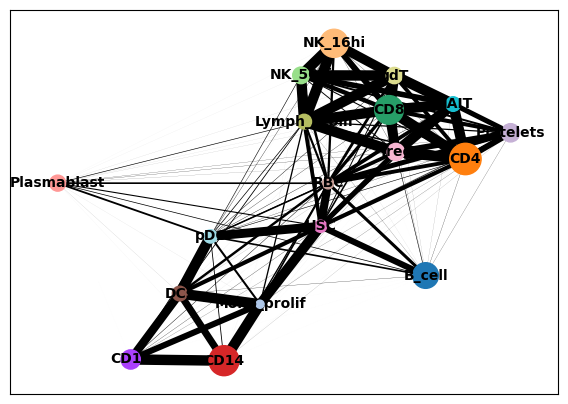

In [12]:
sc.pl.paga(gtdata, plot=True,threshold=0,save='gt_paga_threshold0t10.pdf')

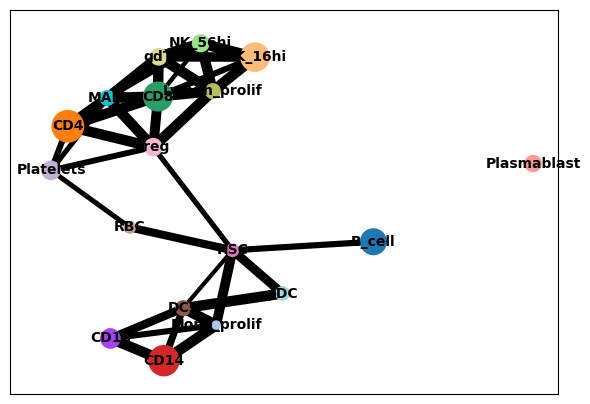

In [23]:
thr = 0.4
sc.pl.paga(gtdata, plot=True,threshold=thr,save='gt_paga_threshold'+str(thr)+'_t10.pdf')

In [10]:
gtpaga = np.array(gtdata.uns['paga']['connectivities'].todense())
semipaga = np.array(semisdata.uns['paga']['connectivities'].todense())
gtpaga = gtpaga.reshape((-1))
semipaga= semipaga.reshape((-1))
scipy.stats.pearsonr(gtpaga,semipaga)

PearsonRResult(statistic=0.8931101741651181, pvalue=9.561019555333109e-114)

In [30]:
gtpaga = np.array(gtdata.uns['paga']['connectivities'].todense())
semipaga = np.array(semisdata.uns['paga']['connectivities'].todense())
gtpaga = gtpaga.reshape((-1))
semipaga= semipaga.reshape((-1))

thr = 0.4
gtpaga = gtpaga*(gtpaga>thr)
semipaga = semipaga*(semipaga>thr)

scipy.stats.pearsonr(gtpaga,semipaga)

PearsonRResult(statistic=0.8506058443819922, pvalue=6.647975237337228e-92)

In [222]:
totaltypes

array(['B_cell', 'CD14', 'CD16', 'CD4', 'CD8', 'DCs', 'HSC',
       'Lymph_prolif', 'MAIT', 'Mono_prolif', 'NK_16hi', 'NK_56hi',
       'Plasmablast', 'Platelets', 'RBC', 'Treg', 'gdT', 'pDC'],
      dtype=object)

In [41]:
path = ['Mono_prolif','CD14','CD16']

### Marker genes dotplot

In [223]:
#gtdata = gtdata[:,hvmask]
sc.tl.rank_genes_groups(gtdata, 'celltypes', method='t-test')

In [224]:
#semisdata.X = semisdata.X * (semisdata.X>np.log1p(1))

In [225]:
sc.tl.rank_genes_groups(semisdata, 'celltypes', method='t-test')

In [102]:
(semisdata.X[semisdata.X>0]).min()

0.0953102

In [226]:
gt_markers = []
semi_markers = []
for j in range(totaltypes.shape[0]):
    typede = []
    for i in range(3):
        g = gtdata.uns['rank_genes_groups']['names'][i][j]
        typede.append(g)
    gt_markers = gt_markers + typede
    
    typede = []
    for i in range(3):
        g = semisdata.uns['rank_genes_groups']['names'][i][j]
        typede.append(g)
    semi_markers = gt_markers + typede
 

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


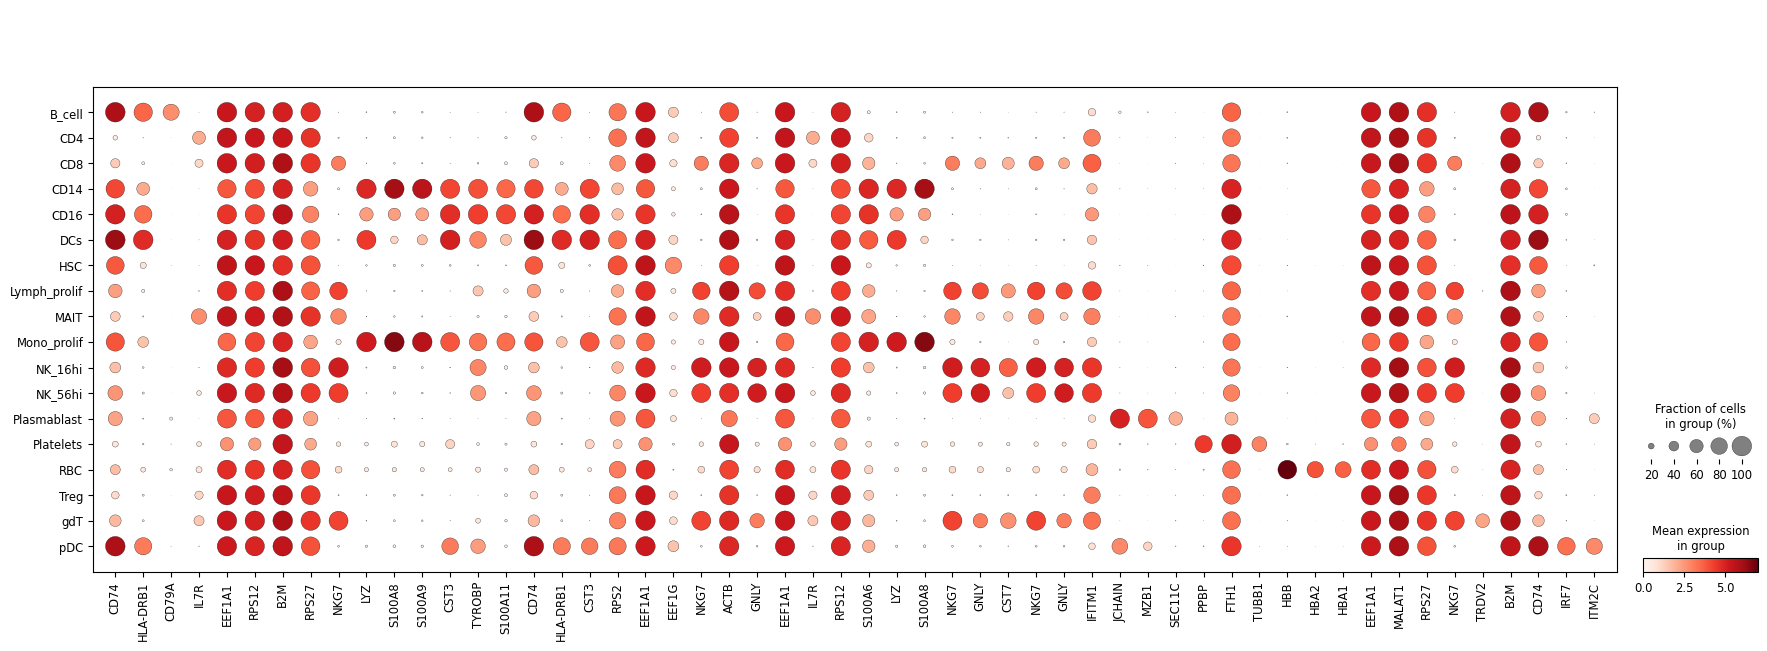

In [227]:
sc.pl.dotplot(gtdata, gt_markers, groupby='celltypes',save = 'dot_gt.pdf')#.style(cmap='Blues',dot_edge_color='black', dot_edge_lw=1).swap_axes(False).show(True)

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


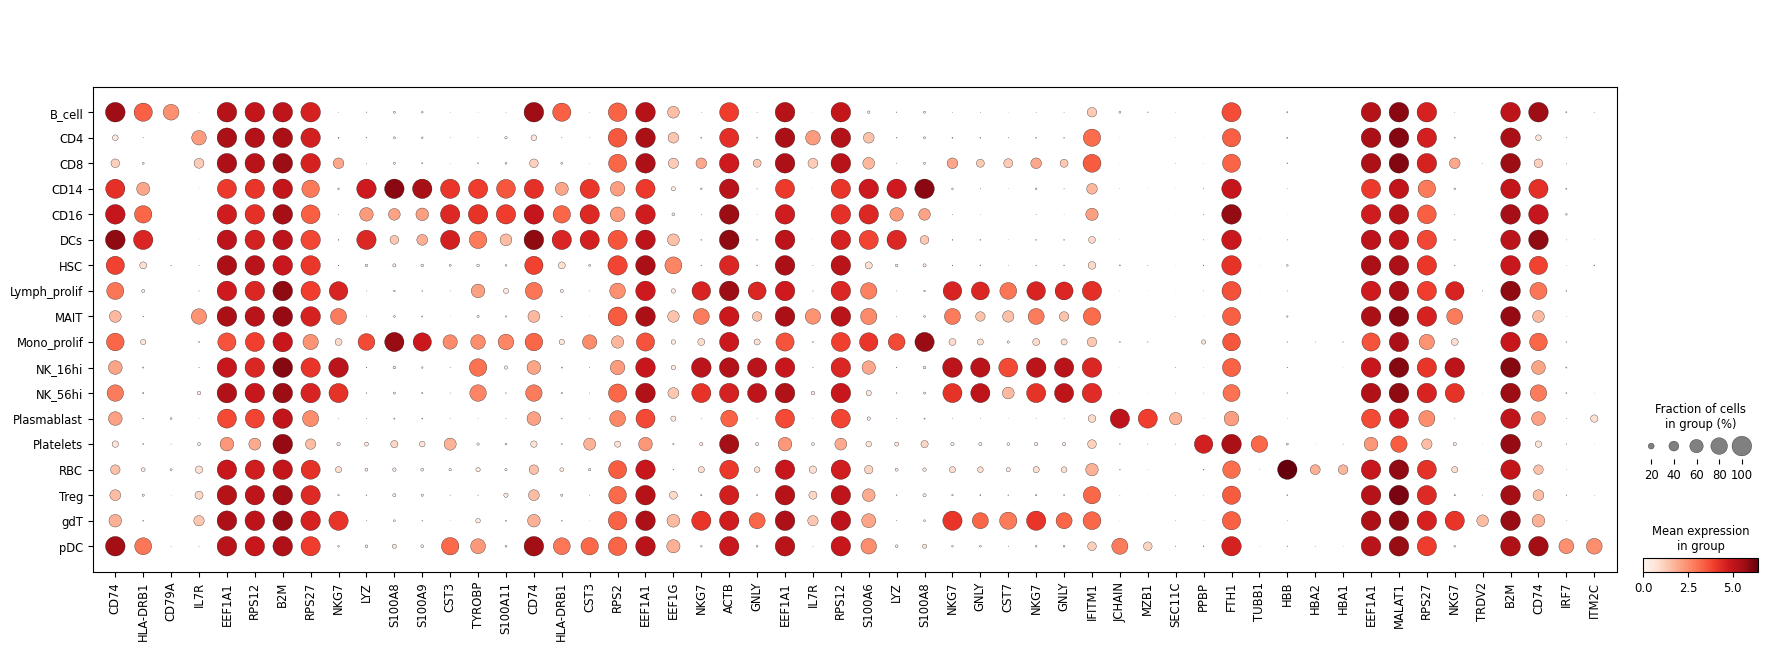

In [228]:
sc.pl.dotplot(semisdata, gt_markers, groupby='initial_clustering',save = 'dot_semi.pdf')#.style(cmap='Blues',dot_edge_color='black', dot_edge_lw=1).swap_axes(False).show(True)

In [229]:
dp = sc.pl.dotplot(semisdata, gt_markers, groupby='initial_clustering',save = 'dot_semi.png',return_fig=True)

In [230]:
dpcolor = (dp.dot_color_df.to_numpy())

In [231]:
dpsize = (dp.dot_size_df.to_numpy())

In [232]:
dpgt = sc.pl.dotplot(gtdata, gt_markers, groupby='celltypes',save = 'dot_gt.png',return_fig=True)

In [233]:
dpgtsize = (dpgt.dot_size_df.to_numpy())
dpgtcolor = (dpgt.dot_color_df.to_numpy())

In [234]:
from scipy import stats

In [235]:
res = stats.pearsonr(dpgtsize.flatten(), dpsize.flatten())

In [236]:
res

PearsonRResult(statistic=0.9913764815744247, pvalue=0.0)

In [237]:
res = stats.pearsonr(dpgtcolor.flatten(), dpcolor.flatten())

In [238]:
res

PearsonRResult(statistic=0.9931361453036925, pvalue=0.0)

In [71]:
semisdata.write('semisdata.h5ad')

In [69]:
gtdata.write('gtdata.h5ad')

### end of pseudotime
### start RRHO

In [239]:
# find both positivee and negative markers
sc.tl.rank_genes_groups(gtdata, 'celltypes', method='t-test',rankby_abs=True)

In [240]:
sc.tl.rank_genes_groups(semisdata, 'initial_clustering', method='t-test',rankby_abs=True)

In [241]:
gtdata.obs['initial_clustering'] = gtdata.obs['celltypes']

In [242]:
from mpmath import *
mp.dps=1000

In [243]:
j=17
celltype = totaltypes[j]
print(celltype)

nummarkers = 1000
gt_posmarkers = []
gt_negmarkers = []
semi_posmarkers = []
semi_negmarkers = []
# gt
for i in range(nummarkers):
    g = gtdata.uns['rank_genes_groups']['names'][i][j]
    score = gtdata.uns['rank_genes_groups']['scores'][i][j]
    if score > 0:
        gt_posmarkers.append(g)
    else:
        gt_negmarkers.append(g)
#semii
for i in range(nummarkers):
    g = semisdata.uns['rank_genes_groups']['names'][i][j]
    score = semisdata.uns['rank_genes_groups']['scores'][i][j]
    if score > 0:
        semi_posmarkers.append(g)
    else:
        semi_negmarkers.append(g)

ngenes = 50
gt_posmarkers = gt_posmarkers[:ngenes]
semi_posmarkers = semi_posmarkers[:ngenes]
gt_negmarkers = gt_negmarkers[:ngenes]
semi_negmarkers = semi_negmarkers[:ngenes]
list1 = gt_posmarkers
list2 = semi_posmarkers

n1 = len(list1) # gt pos
n2 = len(list2) # semi pos


# Calculate the maximum rank to consider
max_rank1 = max(n1, n2)

upper=1e-200
rrho_matrix1 = np.zeros((max_rank1, max_rank1))
for rank1 in range(1, max_rank1 + 1):
    for rank2 in range(1, max_rank1 + 1):
        # Get the top genes up to the cutoff ranks
        top_genes1 = set(list1[:rank1])
        top_genes2 = set(list2[:rank2])
        union = np.unique(list(top_genes1) + list(top_genes2))
        # Calculate the overlap between the two gene sets
        overlap = len(top_genes1.intersection(top_genes2))
        # Calculate the hypergeometric p-value for the overlap
        p_value = hypert(6000,rank1,rank2,overlap)#1 - scipy.stats.hypergeom.cdf(overlap, 6000, rank1, rank2)
        #print(p_value)
        p_value = float(p_value)
        if p_value < upper:
            p_value = upper
        if np.isnan(p_value):
            print(overlap, len(union), rank1, rank2)
        # Store the negative logarithm of the p-value in the RRHO matrix
        rrho_matrix1[rank1 - 1, rank2 - 1] = -np.log10(p_value)

pDC


NameError: name 'hypert' is not defined

In [ ]:

fig, axs = plt.subplots(2, 2,figsize=(6,6))

cmap = 'magma'#'coolwarm' # inferno
vmx = 100
# Plot heatmap in the first quadrant
im1 = axs[0, 0].imshow(rrho_matrix1, cmap=cmap,vmax=vmx, aspect='auto')
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

In [23]:
hypert(6000,rank1,rank2,overlap)

mpf('2.2204460492503131e-16')

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpmath import *
def comb(a,b):
    a=mp.mpf(a)
    b=mp.mpf(b)
    cab = fac(a)/fac(a-b)/fac(b)
    return cab

def hyperp(N,n1,n2,k):
    N = mp.mpf(N)
    n1 = mp.mpf(n1)
    n2 = mp.mpf(n2)
    k = mp.mpf(k)
    p = comb(n2,k)*comb(N-n2,n1-k)/comb(N,n1)
    return p 

def hypert(N,n1,n2,k):
    cdf = mp.mpf(0)
    for i in range(0,int(k)+1):
        cdf += hyperp(N,n1,n2,i)
       # print()
    return (1-cdf)

def rrho_plot(list1, list2, list3, list4, celltype,upperbound=5):

    
    n1 = len(list1) # gt pos
    n2 = len(list2) # semi pos
    n3 = len(list3) # gt neg
    n4 = len(list4) # semi neg

    # Calculate the maximum rank to consider
    max_rank1 = max(n3, n2)
    max_rank2 = max(n3, n4)
    max_rank3 = max(n1, n2)
    max_rank4 = max(n1, n4)

    # Initialize the RRHO plot matrix
    rrho_matrix1 = np.zeros((max_rank1, max_rank1))
    rrho_matrix2 = np.zeros((max_rank2, max_rank2))
    rrho_matrix3 = np.zeros((max_rank3, max_rank3))
    rrho_matrix4 = np.zeros((max_rank4, max_rank4))
    
    # Iterate over different cutoff ranks
    upper=1e-50
    ## ax1 
    for rank1 in range(1, max_rank1 + 1):
        for rank2 in range(1, max_rank1 + 1):
            # Get the top genes up to the cutoff ranks
            top_genes1 = set(list1[:rank1])
            top_genes2 = set(list4[:rank2])
            union = np.unique(list(top_genes1) + list(top_genes2))
            # Calculate the overlap between the two gene sets
            overlap = len(top_genes1.intersection(top_genes2))
            # Calculate the hypergeometric p-value for the overlap
            p_value = hypert(int(hvmask.sum()),rank1,rank2,overlap)#1 - scipy.stats.hypergeom.cdf(overlap, 6000, rank1, rank2)
            #print(p_value)
            p_value = float(p_value)
            if p_value < upper:
                p_value = upper
            if np.isnan(p_value):
                print(overlap, len(union), rank1, rank2)
            # Store the negative logarithm of the p-value in the RRHO matrix
            rrho_matrix1[rank1 - 1, rank2 - 1] = -np.log10(p_value)
    #ax2
    for rank1 in range(1, max_rank2 + 1):
        for rank2 in range(1, max_rank2 + 1):
            # Get the top genes up to the cutoff ranks
            top_genes1 = set(list1[:rank1])
            top_genes2 = set(list2[:rank2])
            union = np.unique(list(top_genes1) + list(top_genes2))
            # Calculate the overlap between the two gene sets
            overlap = len(top_genes1.intersection(top_genes2))
            # Calculate the hypergeometric p-value for the overlap
            p_value = hypert(int(hvmask.sum()),rank1,rank2,overlap)#1 - scipy.stats.hypergeom.cdf(overlap, 6000, rank1, rank2)
            #print(p_value)
            p_value = float(p_value)
            if p_value < upper:
                p_value = upper
            if np.isnan(p_value):
                print(overlap, len(union), rank1, rank2)
            # Store the negative logarithm of the p-value in the RRHO matrix
            rrho_matrix2[rank1 - 1, rank2 - 1] = -np.log10(p_value)
            
    for rank1 in range(1, max_rank3 + 1):
        for rank2 in range(1, max_rank3 + 1):
            # Get the top genes up to the cutoff ranks
            top_genes1 = set(list3[:rank1])
            top_genes2 = set(list4[:rank2])
            union = np.unique(list(top_genes1) + list(top_genes2))
            # Calculate the overlap between the two gene sets
            overlap = len(top_genes1.intersection(top_genes2))
            # Calculate the hypergeometric p-value for the overlap
            p_value = hypert(int(hvmask.sum()),rank1,rank2,overlap)#1 - scipy.stats.hypergeom.cdf(overlap, 6000, rank1, rank2)
            #print(p_value)
            p_value = float(p_value)
            if p_value < upper:
                p_value = upper
            if np.isnan(p_value):
                print(overlap, len(union), rank1, rank2)
            # Store the negative logarithm of the p-value in the RRHO matrix
            rrho_matrix3[rank1 - 1, rank2 - 1] = -np.log10(p_value)
            
    for rank1 in range(1, max_rank4 + 1):
        for rank2 in range(1, max_rank4 + 1):
            # Get the top genes up to the cutoff ranks
            top_genes1 = set(list3[:rank1])
            top_genes2 = set(list2[:rank2])
            union = np.unique(list(top_genes1) + list(top_genes2))
            # Calculate the overlap between the two gene sets
            overlap = len(top_genes1.intersection(top_genes2))
            # Calculate the hypergeometric p-value for the overlap
            p_value = hypert(int(hvmask.sum()),rank1,rank2,overlap)#1 - scipy.stats.hypergeom.cdf(overlap, 6000, rank1, rank2)
            #print(p_value)
            p_value = float(p_value)
            if p_value < upper:
                p_value = upper
            if np.isnan(p_value):
                print(overlap, len(union), rank1, rank2)
            # Store the negative logarithm of the p-value in the RRHO matrix
            rrho_matrix4[rank1 - 1, rank2 - 1] = -np.log10(p_value)
            
            
    fig, axs = plt.subplots(2, 2,figsize=(6,6))

    cmap = 'magma'#'coolwarm' # inferno
    
    rrho_matrix2 = np.flip(rrho_matrix2,axis=1)
    rrho_matrix3 = np.flip(rrho_matrix3,axis=0)
    rrho_matrix4 = np.flip(np.flip(rrho_matrix4,axis=0),axis=1)
    
    vmx = 50
    # Plot heatmap in the first quadrant
    im1 = axs[0, 0].imshow(rrho_matrix1, cmap=cmap,vmax=vmx, aspect='auto')
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])
    # Plot heatmap in the second quadrant
    im2 = axs[0, 1].imshow(rrho_matrix2, cmap=cmap,vmax=vmx, aspect='auto')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    # Plot heatmap in the third quadrant
    im3 = axs[1, 0].imshow(rrho_matrix3, cmap=cmap,vmax=vmx, aspect='auto')
    axs[1, 0].set_xticks([])
    axs[1, 0].set_yticks([])
    # Plot heatmap in the fourth quadrant
    im4 = axs[1, 1].imshow(rrho_matrix4, cmap=cmap,vmax=vmx, aspect='auto')
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])
    #plt.title(celltype + ' Markers RRHO Plot')
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.savefig('results/RRHO50_'+celltype+'.pdf')
    plt.show()
    # Plot the RRHO heatmap
    
    plt.imshow(rrho_matrix2, cmap=cmap, aspect='auto')
    plt.colorbar(label='-log10(p)')
    #plt.xlabel('Semii-profiled Markers')
    #plt.ylabel('Real Markers')
    #plt.title(celltype + ' Markers RRHO Plot')

    plt.xticks(list(range(0,n1,n1//10))) 
    plt.yticks(list(range(0,n2,n2//10))) 

    #plt.clim(0,upperbound)
    plt.savefig('results/RRHO50_colorbar.pdf')
    plt.show()
    
    return rrho_matrix1,rrho_matrix2,rrho_matrix3,rrho_matrix4




In [245]:
def rrho(j=0,nummarkers=100,upperbound=5):
    gt_markers1 = []
    semi_markers1 = []

    celltype = totaltypes[j]

    for i in range(nummarkers):
        g = gtdata.uns['rank_genes_groups']['names'][i][j]
        gt_markers1.append(g)
    for i in range(nummarkers):
        g = semisdata.uns['rank_genes_groups']['names'][i][j]
        semi_markers1.append(g)

    rmat = rrho_plot(gt_markers1, semi_markers1,celltype,upperbound)

In [246]:
mp.dps=200

NK_56hi


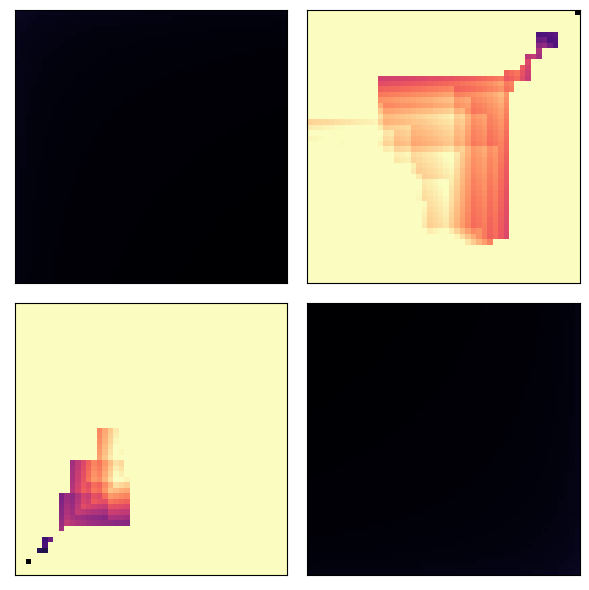

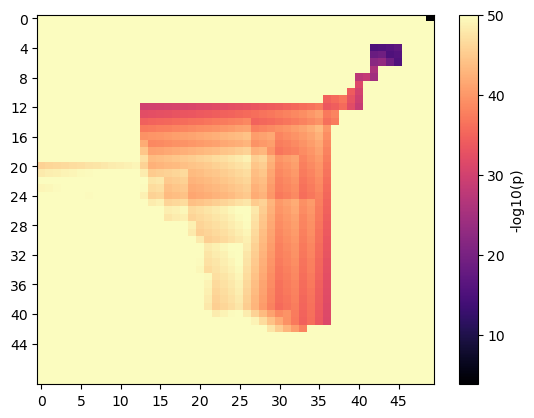

Plasmablast


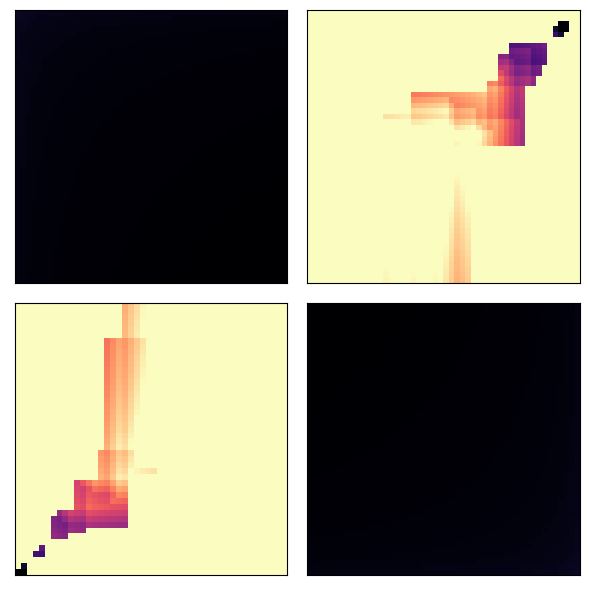

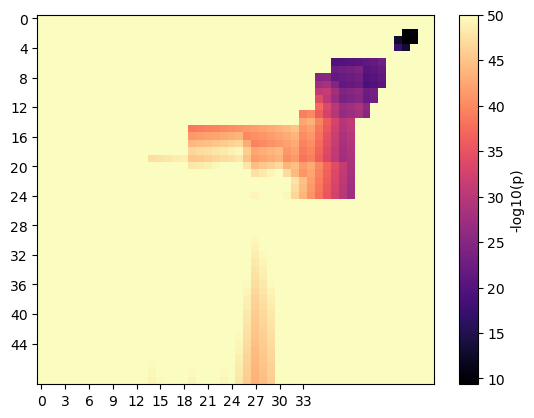

Platelets


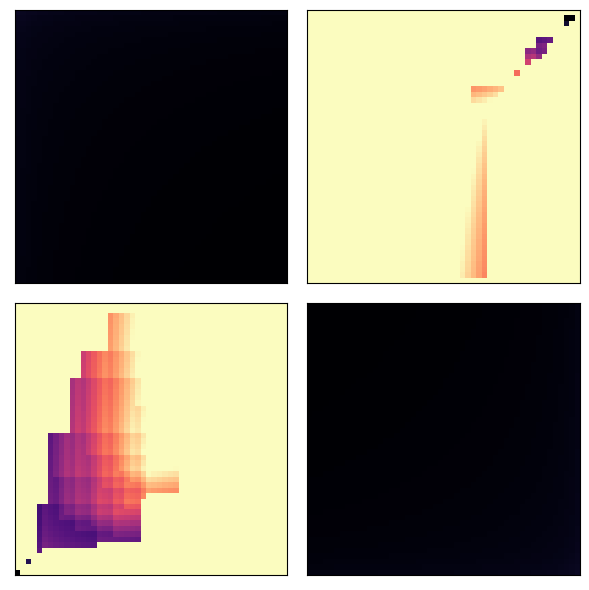

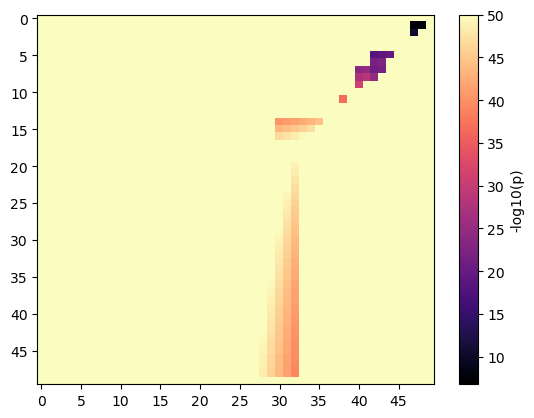

RBC


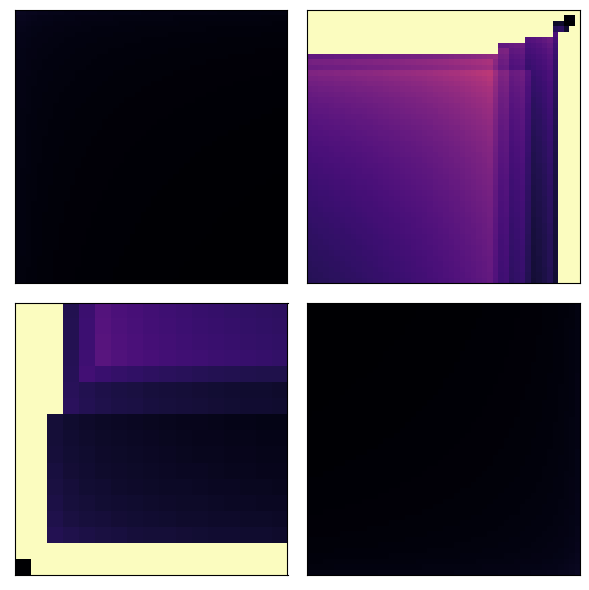

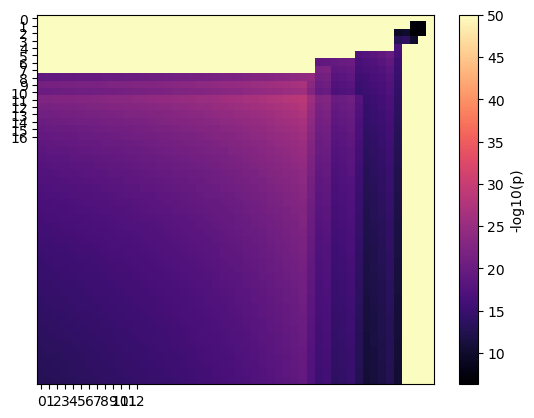

Treg


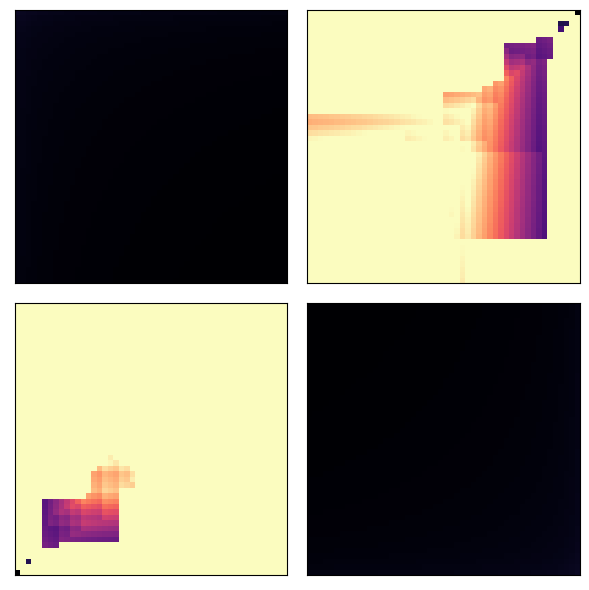

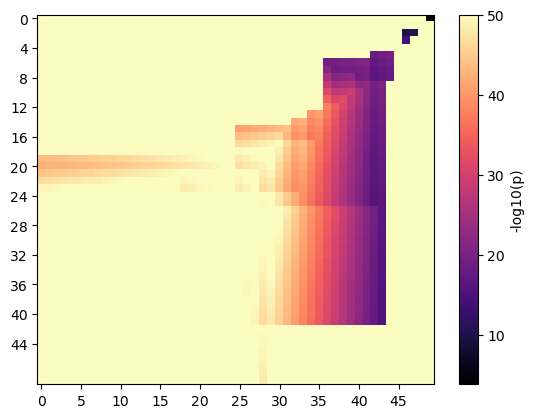

gdT


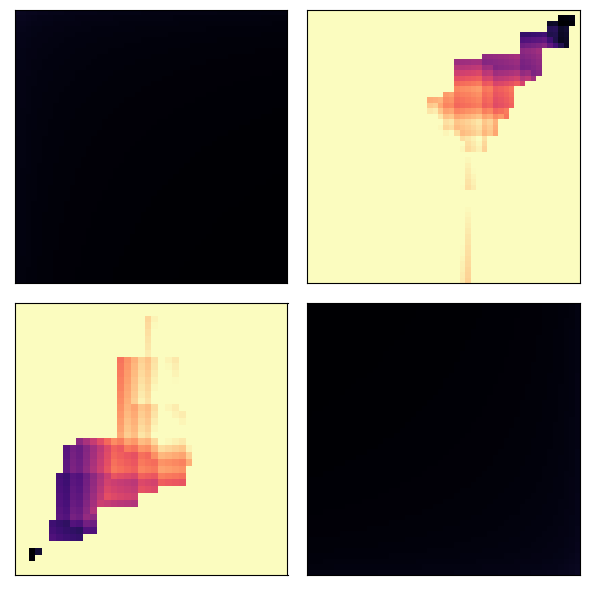

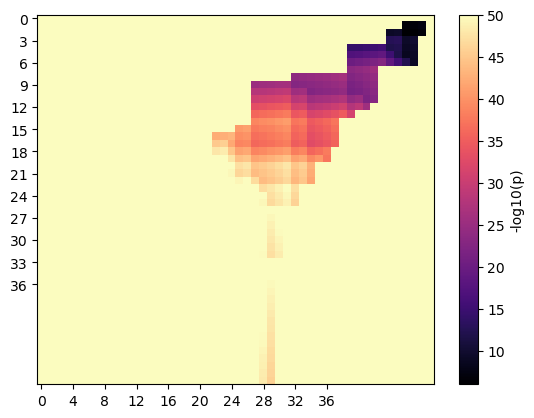

pDC


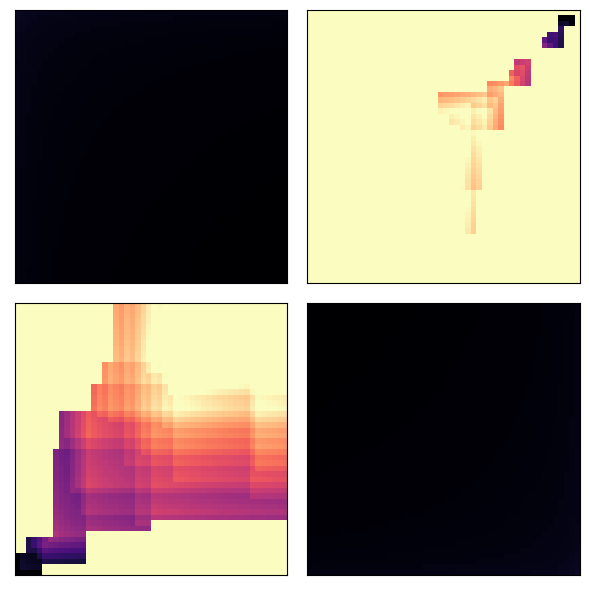

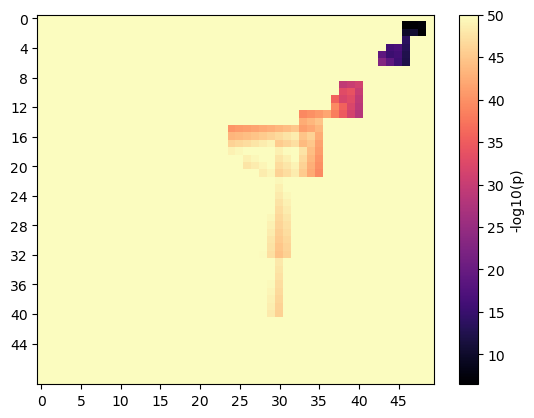

In [249]:
upperbound=50
for j in range(11,len(totaltypes)):#18):
    celltype = totaltypes[j]
    print(celltype)

    nummarkers = 1000
    gt_posmarkers = []
    gt_negmarkers = []
    semi_posmarkers = []
    semi_negmarkers = []
    # gt
    for i in range(nummarkers):
        g = gtdata.uns['rank_genes_groups']['names'][i][j]
        score = gtdata.uns['rank_genes_groups']['scores'][i][j]
        if score > 0:
            gt_posmarkers.append(g)
        else:
            gt_negmarkers.append(g)
    #semii
    for i in range(nummarkers):
        g = semisdata.uns['rank_genes_groups']['names'][i][j]
        score = semisdata.uns['rank_genes_groups']['scores'][i][j]
        if score > 0:
            semi_posmarkers.append(g)
        else:
            semi_negmarkers.append(g)

    ngenes = 50
    gt_posmarkers = gt_posmarkers[:ngenes]
    semi_posmarkers = semi_posmarkers[:ngenes]
    gt_negmarkers = gt_negmarkers[:ngenes]
    semi_negmarkers = semi_negmarkers[:ngenes]
    #print(len(gt_posmarkers))
    #print(len(semi_posmarkers))
    #print(len(gt_negmarkers))
    #print(len(semi_negmarkers))
    rmat = rrho_plot(list1 = gt_posmarkers, \
                     list2 = semi_posmarkers,\
                     list3 = gt_negmarkers,\
                     list4 = semi_negmarkers,\
                     celltype = celltype, upperbound = upperbound)

In [35]:
totalterms = 14
print('pval:',float(hypert(6000,10,10,20 - totalterms)))

pval: 2.5982681679311674e-19


In [231]:
gtdata

AnnData object with n_obs × n_vars = 637144 × 6030
    obs: 'status', 'status_collection', 'states_collection_sum', 'celltypes', 'subtypes', 'repmask', 'IFN_score', 'patient_id', 'ft', 'initial_clustering'
    var: 'feature_types'
    uns: 'rank_genes_groups', 'ft_colors', 'neighbors', 'paga', 'celltypes_sizes', 'celltypes_colors'
    obsm: 'X_pca', 'X_pca_joint', 'X_umap', 'X_umap_joint'
    obsp: 'distances', 'connectivities'

In [233]:
semisdata

AnnData object with n_obs × n_vars = 676390 × 6030
    obs: 'status', 'status_collection', 'Status_on_day_collection_summary', 'IFN_score', 'initial_clustering'
    var: 'feature_types'
    uns: 'rank_genes_groups', 'initial_clustering_colors', 'neighbors', 'paga', 'initial_clustering_sizes'
    obsm: 'X_pca', 'X_pca_joint', 'X_umap_joint', 'X_umap'
    obsp: 'distances', 'connectivities'

In [8]:
np.unique(gtdata.obs['states_collection_sum'])

array(['Asymptomatic', 'Critical', 'Healthy', 'LPS_10hours', 'LPS_90mins',
       'Mild', 'Moderate', 'Non_covid', 'Severe'], dtype=object)

In [253]:
healthygt = gtdata[gtdata.obs['states_collection_sum']=='Healthy']
healthysemi = semisdata[semisdata.obs['states_collection_sum']=='Healthy']
severegt = gtdata[gtdata.obs['states_collection_sum']=='Severe']
severesemi = semisdata[semisdata.obs['states_collection_sum']=='Severe']

In [254]:
criticalgt = gtdata[gtdata.obs['states_collection_sum']=='Critical']
criticalsemi = semisdata[semisdata.obs['states_collection_sum']=='Critical']
asymptomaticgt = gtdata[gtdata.obs['states_collection_sum']=='Asymptomatic']
asymptomaticsemi = semisdata[semisdata.obs['states_collection_sum']=='Asymptomatic']

mildgt = gtdata[gtdata.obs['states_collection_sum']=='Mild']
mildsemi = semisdata[semisdata.obs['states_collection_sum']=='Mild']
moderategt = gtdata[gtdata.obs['states_collection_sum']=='Moderate']
moderatesemi = semisdata[semisdata.obs['states_collection_sum']=='Moderate']

nongt = gtdata[gtdata.obs['states_collection_sum']=='Non_covid']
nonsemi = semisdata[semisdata.obs['states_collection_sum']=='Non_covid']



In [255]:
gtdata

AnnData object with n_obs × n_vars = 637144 × 6030
    obs: 'status', 'status_collection', 'states_collection_sum', 'celltypes', 'subtypes', 'repmask', 'ft', 'IFN_score', 'sample_ids', 'sample_id', 'initial_clustering'
    var: 'feature_types'
    uns: 'ft_colors', 'rank_genes_groups', 'neighbors', 'paga', 'celltypes_sizes', 'celltypes_colors'
    obsm: 'X_pca_joint', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [256]:
healthysemi.write('typedata/healthysemi.h5ad')
severesemi.write('typedata/severesemi.h5ad')
healthygt.write('typedata/healthygt.h5ad')
severegt.write('typedata/severegt.h5ad')

In [257]:
criticalgt.write('typedata/criticalgt.h5ad')
criticalsemi.write('typedata/criticalsemi.h5ad')
asymptomaticgt.write('typedata/asymptomaticgt.h5ad')
asymptomaticsemi.write('typedata/asymptomaticsemi.h5ad')

mildgt.write('typedata/mildgt.h5ad')
mildsemi.write('typedata/mildsemi.h5ad')
moderategt.write('typedata/moderategt.h5ad')
moderatesemi.write('typedata/moderatesemi.h5ad')

nongt.write('typedata/nongt.h5ad')
nonsemi.write('typedata/nonsemi.h5ad')

In [258]:
totaltypes

array(['B_cell', 'CD14', 'CD16', 'CD4', 'CD8', 'DCs', 'HSC',
       'Lymph_prolif', 'MAIT', 'Mono_prolif', 'NK_16hi', 'NK_56hi',
       'Plasmablast', 'Platelets', 'RBC', 'Treg', 'gdT', 'pDC'],
      dtype=object)

In [259]:
gtdata[gtdata.obs['celltypes'] == 'B_cell'].write('typedata/gtB_cell.h5ad')

In [260]:
gtdata[gtdata.obs['celltypes'] == 'CD8'].write('typedata/gt_CD8.h5ad')

In [261]:
semisdata[semisdata.obs['initial_clustering'] == 'B_cell'].write('typedata/semi_B_cell.h5ad')

In [ ]:
semisdata